# ARIMAX_SE with GRIDSEARCH_CV and PCA on ADM0, QUARTERLY

In [1]:
import pandas as pd

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

import warnings
warnings.simplefilter('ignore')

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
    
import time
import datetime

import os

## Model Specifications

In [2]:
TARGET_VARIABLE = "SUM(FATALITIES)"
SEASONAL_PERIODICITY = 4 # for data frequency & seasonality S

SEASONALITY = False
NEIGHBORS = False # X_N
SOCIO_ECO_VARS = True # X_SE
N_LAGS_X = 1 # todo: remove or change behavior from max lags to lag
DIM_REDUCTION_METHOD = "PCA"

if SEASONALITY:
    CV_FOLDS = 5
else:
    CV_FOLDS = 1

In [3]:
MODEL_NAME = ""
if SEASONALITY:
    MODEL_NAME += "S" 
    
MODEL_NAME += "ARIMA"

if SOCIO_ECO_VARS and NEIGHBORS:
    MODEL_NAME += "X_SE+N"
    
if SOCIO_ECO_VARS and not NEIGHBORS:
    MODEL_NAME += "X_SE"
    
if not SOCIO_ECO_VARS and NEIGHBORS:
    MODEL_NAME += "X_N"
    
if SEASONAL_PERIODICITY ==  12:
    MODEL_NAME += "_MONTHLY"
elif SEASONAL_PERIODICITY == 4:
    MODEL_NAME += "_QUARTERLY"

MODEL_NAME

'ARIMAX_SE_QUARTERLY'

### Hyperparameter Grid

In [4]:
# create a set of sarima configs to try
PARAM_GRID = list()
# parameter options to try

### PCA
if NEIGHBORS or SOCIO_ECO_VARS:
    n_components = range(0, 4) # include up to three main components
else:
    n_components = [0]
    

### ARMA
p_params = range(4) # AR 3
d_params = range(2) # Differencing 1
q_params = range(4) # MA 3


### SEASONALITY
if SEASONALITY:
    P_params = range(3) # 5
    D_params = range(2) # 1
    Q_params = range(3) # 2
    
    ### TREND
    # t_params = ['n','c','t','ct'] # Form of Trend
    # t_params = ['n', 't', 'ct'] # Form of Trend
    t_params = ["n"]

    ### SEASONAL PERIODICITY
    m_params = [SEASONAL_PERIODICITY]   
else:
    P_params = [0]
    D_params = [0]
    Q_params = [0]

    t_params = ["n"] # Form of Trend

    m_params = [0] 

for n in n_components:
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                for t in t_params:
                                    cfg = [n, (p, d, q), (P, D, Q, m), t]
                                    PARAM_GRID.append(cfg)
len(PARAM_GRID)    

128

## Model Training

In [5]:
from common_functions import *
from forecasters import *

#### Training Method

In [6]:
def varimax(target_variable="SUM(FATALITIES)", 
            target_country="MLI", 
            predictor_countries=["BFA"], 
            n_lags_X = N_LAGS_X, 
            seasonal_periodicity = SEASONAL_PERIODICITY):
        
    ### GET DATA
    y, X = getData(target_variable = target_variable, 
                   target_country = target_country, 
                   predictor_countries = predictor_countries,
                   socio_eco_vars = SOCIO_ECO_VARS,
                   n_lags_X = N_LAGS_X, 
                   seasonal_periodicity = SEASONAL_PERIODICITY)
    
    ### SPLIT DATA
    X_train, X_test, y_train, y_test = train_test_split(y = y,
                                                        X = X, 
                                                        forecast_horizon = SEASONAL_PERIODICITY)
    
    ### TRAINING WITH GRIDSEARCHCV
    gscv = GridSearchCV(param_grid = PARAM_GRID,
                        forecaster = TimeSeriesForecasterPCA_LinInt,
                        seasonal_periodicity = SEASONAL_PERIODICITY,
                        cv_folds = CV_FOLDS)
    training_res = gscv.train(X_train, y_train)

    if training_res is not None:
        model = gscv
        # print ARIMA summary
        print(training_res)
        print(model.best_model_result.mle_retvals)
        plt.tight_layout()
        try:
            model.best_model_result.plot_diagnostics(figsize=(16*0.7, 10*0.7), lags = SEASONAL_PERIODICITY+1)
        except: 
            pass
        best_parameters = str(model.best_model_cv_results)
        
    else:
        print("No model fitted --> Prediction with Naive Model ")
        model = NoChange().fit(X_train, y_train)
        best_parameters = np.nan
        
    ### PREDICTION
    prediction_results = model.evaluate_model(X_test, y_test, fh = SEASONAL_PERIODICITY)
    
    if prediction_results["FAT_PRED"].isnull().values.any():
        model = NoChange().fit(X_train, y_train)
        print("Model Prediction failed --> Prediction with Naive Model ")
        model = NoChange().fit(X_train, y_train)
        best_parameters = np.nan
        prediction_results = model.evaluate_model(X_test, y_test, fh = SEASONAL_PERIODICITY)


    
    ### ADJUST RESULT DF
    prediction_results["GID_0"] = target_country
    prediction_results["MONTH"] = pd.to_datetime(prediction_results["MONTH"].astype(str)) 
    prediction_results["PARAMETERS"] = best_parameters

    print(prediction_results)

    return prediction_results

#### Automated Training for all 234 Countries 

In [7]:
acled_monthly_adm0 = pd.read_csv("../data/TB003_EVENT_OUTCOMES_MONTHLY_START_DATE.csv")
gid0_neighbors = pd.read_csv("../data/GID_0_Neighbours.csv")
# gid_list = acled_monthly_adm0["GID_0"].unique()[::-1] #reverse
gid_list = acled_monthly_adm0["GID_0"].unique()
len(gid_list)

234

File already exists.
######## ABW (1/234) #########
4
Model for this country has already been fitted.
######## AFG (2/234) #########
4
Model for this country has already been fitted.
######## AGO (3/234) #########
4
Model for this country has already been fitted.
######## AIA (4/234) #########
4
Model for this country has already been fitted.
######## ALA (5/234) #########
4
Model for this country has already been fitted.
######## ALB (6/234) #########
4
Model for this country has already been fitted.
######## AND (7/234) #########
4
Model for this country has already been fitted.
######## ARE (8/234) #########
4
Model for this country has already been fitted.
######## ARG (9/234) #########
4
Model for this country has already been fitted.
######## ARM (10/234) #########
4
Model for this country has already been fitted.
######## ASM (11/234) #########
4
Model for this country has already been fitted.
######## ATA (12/234) #########
4
Model for this country has already been fitted.
####

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (49, 94)
y: (49, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], 'cv_score': 0.45931257551650406, 'fold_results': [0.45931257551650406]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_THA   No. Observations:                   45
Model:                SARIMAX(2, 0, 3)   Log Likelihood                 -26.613
Date:                 Sat, 03 Sep 2022   AIC                             67.227
Time:                         20:00:03   BIC                             79.873
Sample:                     01-31-2010   HQIC                            71.941
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0645      0.016      4.051    

<Figure size 432x288 with 0 Axes>

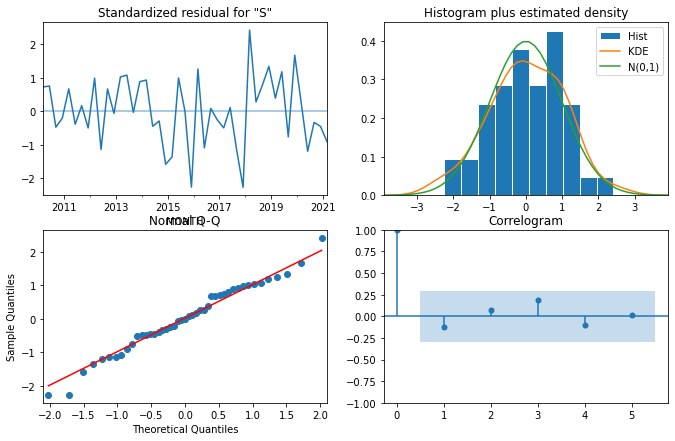

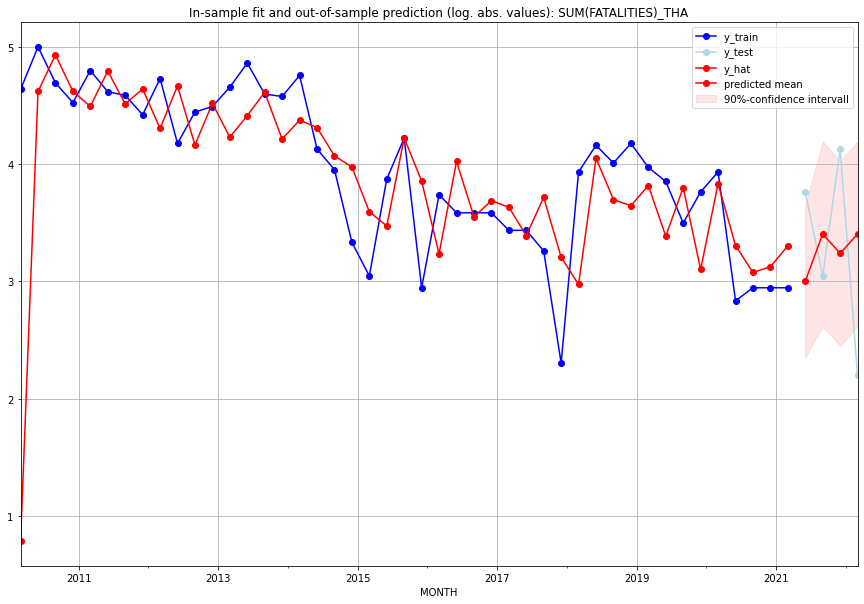

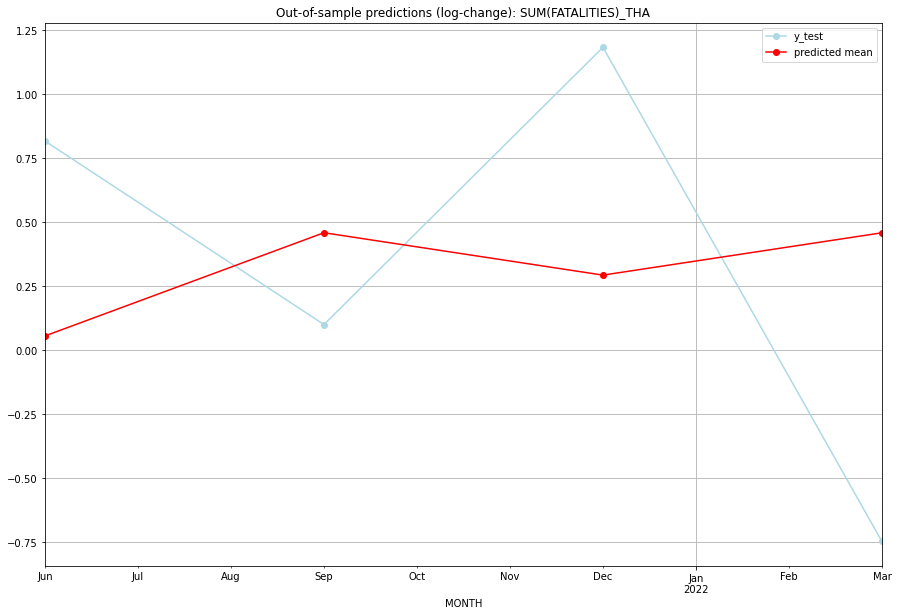

TADDA: 0.9183030645345158
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  19.085511        42.0      0.055560        0.816761   THA   
1 2021-07-01  29.053675        20.0      0.458546        0.100083   THA   
2 2021-10-01  24.469356        61.0      0.293037        1.182695   THA   
3 2022-01-01  29.047419         8.0      0.458338       -0.747214   THA   

                                          PARAMETERS  
0  {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
1  {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
2  {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
3  {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:52
######## TJK (204/234) #########
0
Neighbor countries: []
Getting Data for TJK
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 92)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.27465307216702745, 'fold_results': [0.27465307216702745]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_TJK   No. Observations:                   13
Model:                         SARIMAX   Log Likelihood                 -27.575
Date:                 Sat, 03 Sep 2022   AIC                             57.151
Time:                         20:00:27   BIC                             57.716
Sample:                     01-31-2018   HQIC                            57.034
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.0734      1.792      2.274    

<Figure size 432x288 with 0 Axes>

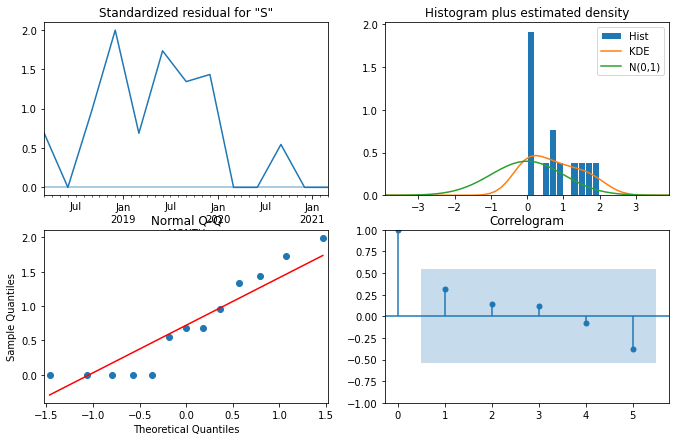

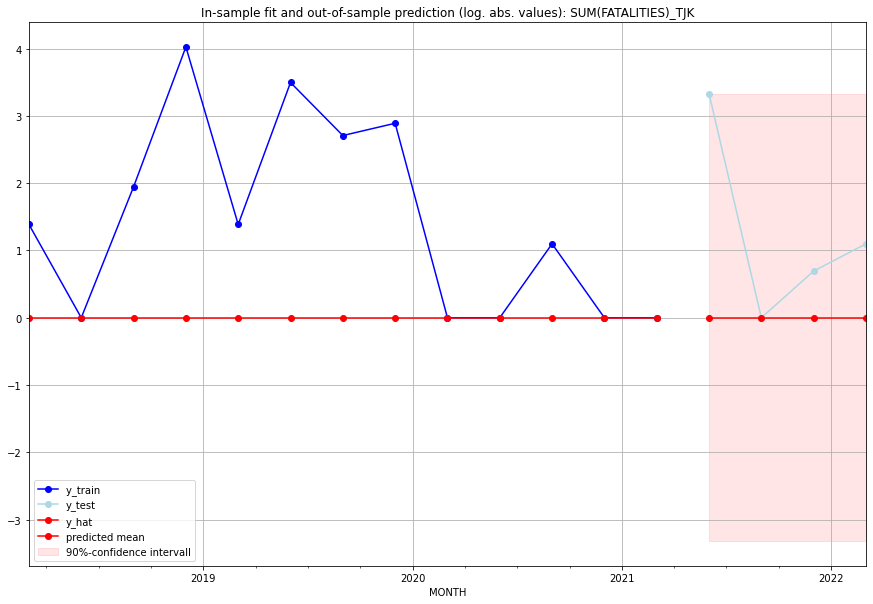

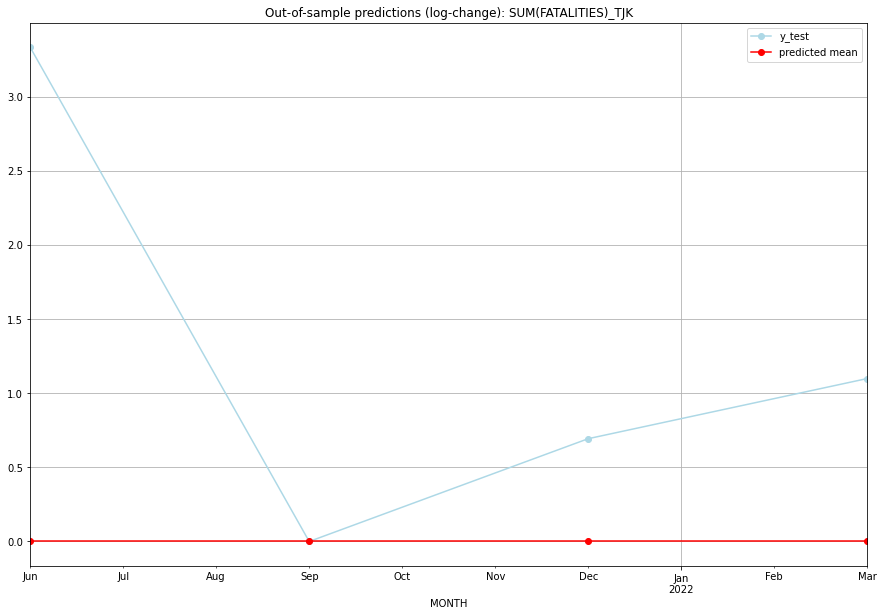

TADDA: 1.2809909948508147
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0        27.0           0.0        3.332205   TJK   
1 2021-07-01       0.0         0.0           0.0        0.000000   TJK   
2 2021-10-01       0.0         1.0           0.0        0.693147   TJK   
3 2022-01-01       0.0         2.0           0.0        1.098612   TJK   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:21
######## TKM (205/234) #########
0
Neighbor countries: []
Getting Data for TKM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 77)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU core

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [2, (0, 0, 3), (0, 0, 0, 0), 'n'], 'cv_score': 0.13630859370906476, 'fold_results': [0.13630859370906476]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_TKM   No. Observations:                   13
Model:                SARIMAX(0, 0, 3)   Log Likelihood                 -17.925
Date:                 Sat, 03 Sep 2022   AIC                             47.849
Time:                         20:00:43   BIC                             51.239
Sample:                     01-31-2018   HQIC                            47.152
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0433      0.050      0.868    

<Figure size 432x288 with 0 Axes>

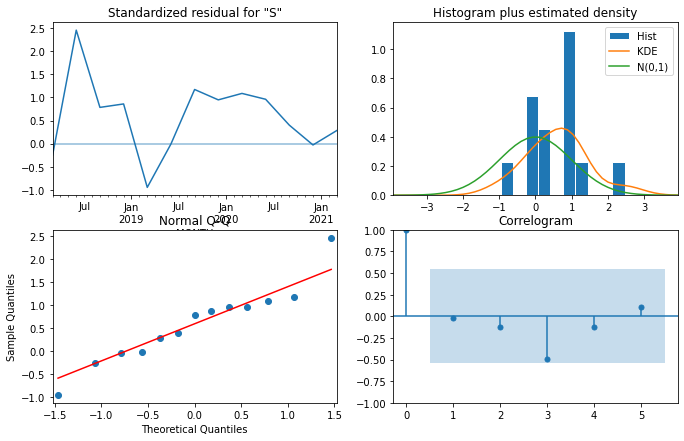

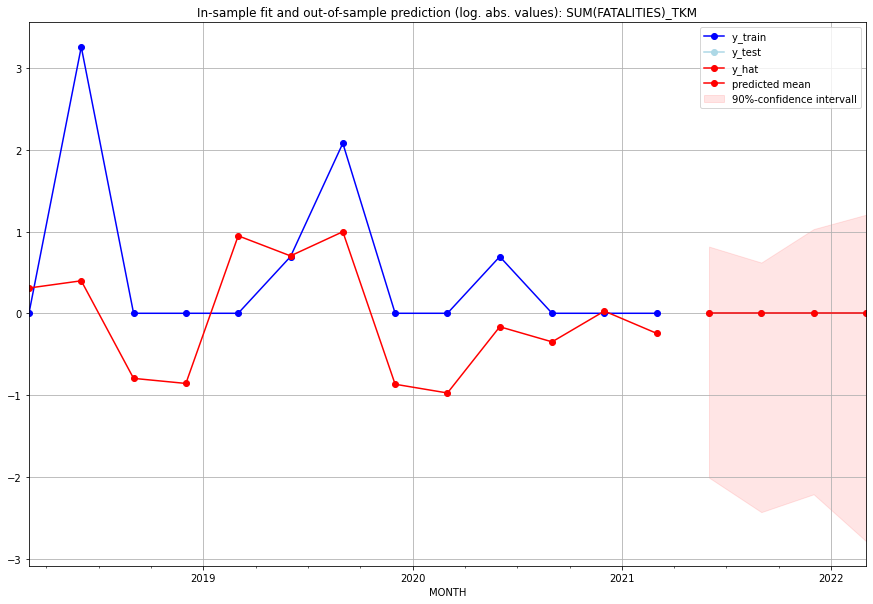

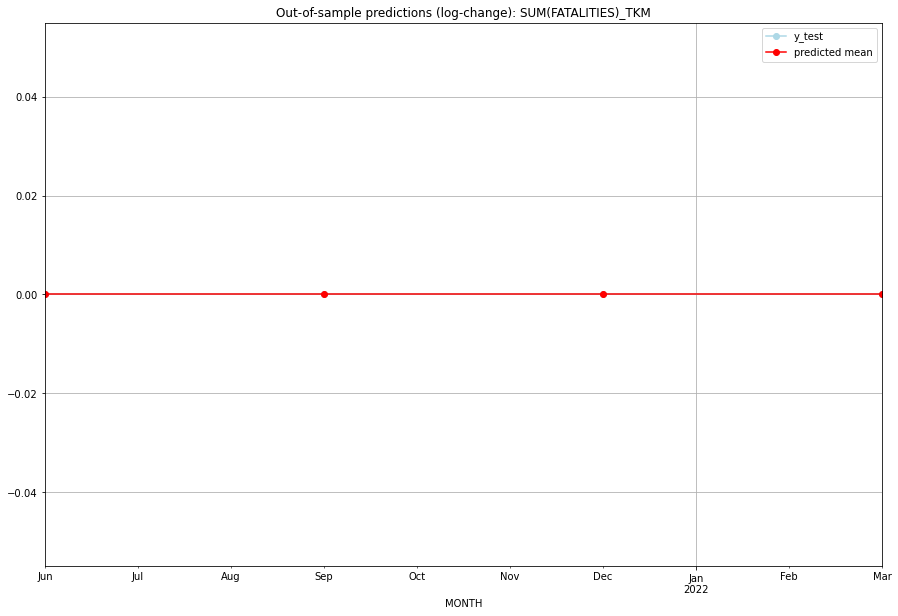

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   TKM   
1 2021-07-01       0.0         0.0           0.0             0.0   TKM   
2 2021-10-01       0.0         0.0           0.0             0.0   TKM   
3 2022-01-01       0.0         0.0           0.0             0.0   TKM   

                                          PARAMETERS  
0  {'params': [2, (0, 0, 3), (0, 0, 0, 0), 'n'], ...  
1  {'params': [2, (0, 0, 3), (0, 0, 0, 0), 'n'], ...  
2  {'params': [2, (0, 0, 3), (0, 0, 0, 0), 'n'], ...  
3  {'params': [2, (0, 0, 3), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:15
######## TLS (206/234) #########
0
Neighbor countries: []
Getting Data for TLS
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 83)
y: (100, 1)
------------------------------------------------
Training started.
y_train is constant. No GSCV necessary.
No mod

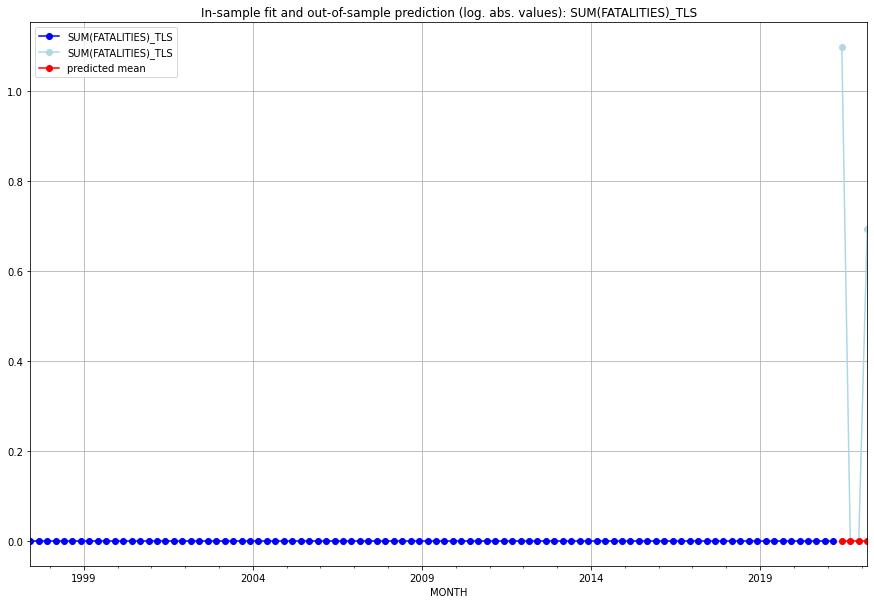

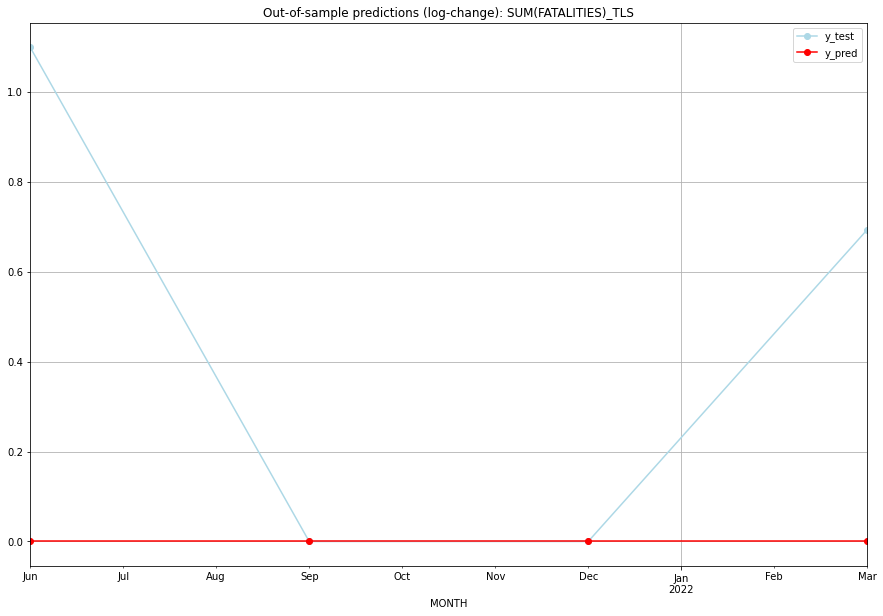

TADDA: 0.44793986730701374
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0    1.098612           0.0        1.098612   TLS   
1 2021-07-01       0.0    0.000000           0.0        0.000000   TLS   
2 2021-10-01       0.0    0.000000           0.0        0.000000   TLS   
3 2022-01-01       0.0    0.693147           0.0        0.693147   TLS   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:02
######## TON (207/234) #########
0
Neighbor countries: []
Getting Data for TON
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 84)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


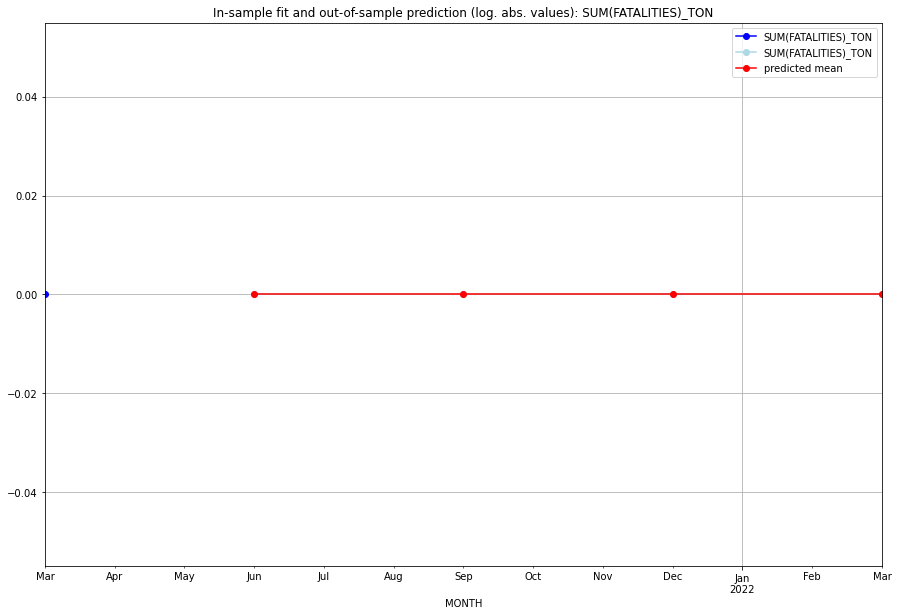

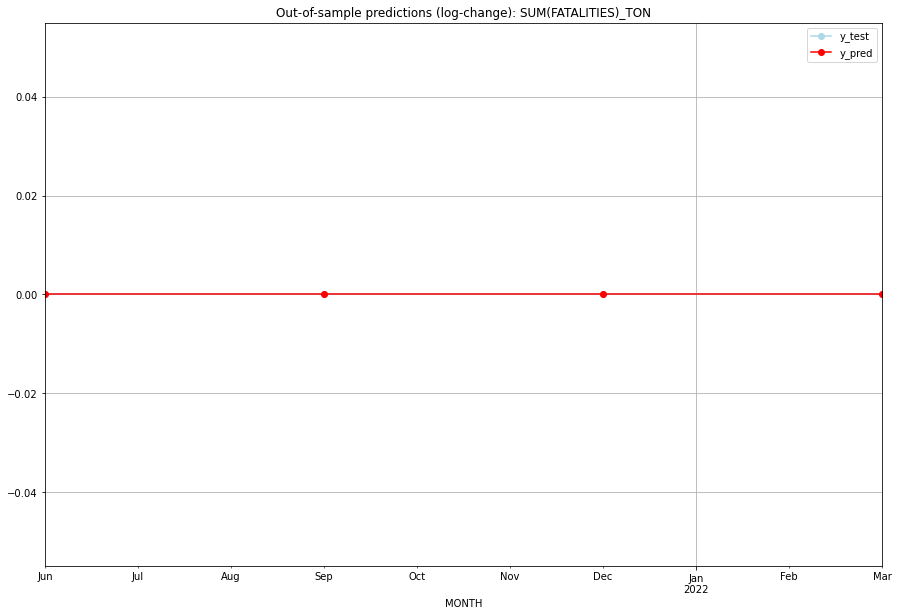

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   TON   
1 2021-07-01       0.0         0.0           0.0             0.0   TON   
2 2021-10-01       0.0         0.0           0.0             0.0   TON   
3 2022-01-01       0.0         0.0           0.0             0.0   TON   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:05
######## TTO (208/234) #########
0
Neighbor countries: []
Getting Data for TTO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 80)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 3), (0, 0, 0, 0), 'n'], 'cv_score': 0.45288018284100495, 'fold_results': [0.45288018284100495]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_TTO   No. Observations:                   13
Model:                SARIMAX(0, 1, 3)   Log Likelihood                     nan
Date:                 Sat, 03 Sep 2022   AIC                                nan
Time:                         20:01:15   BIC                                nan
Sample:                     01-31-2018   HQIC                               nan
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1               0        nan        nan    

<Figure size 432x288 with 0 Axes>

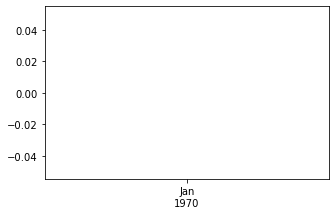

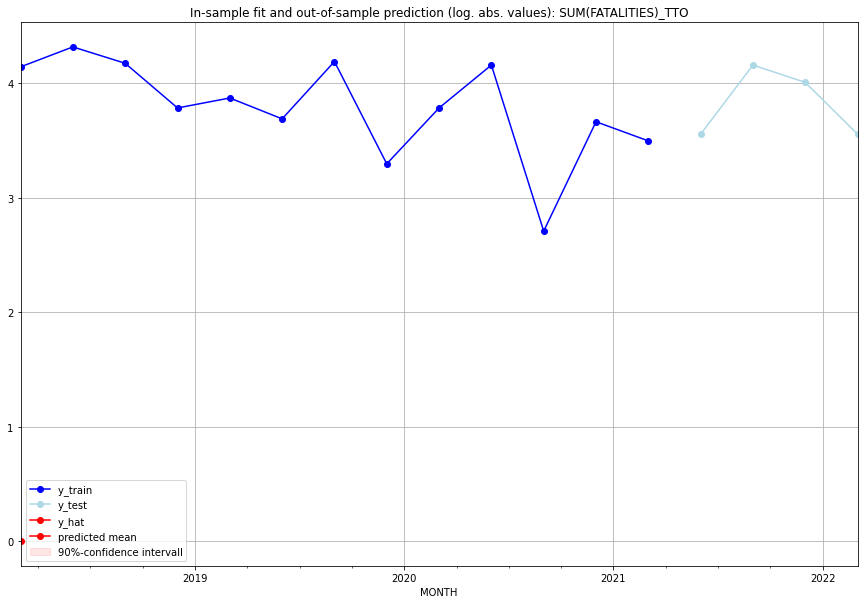

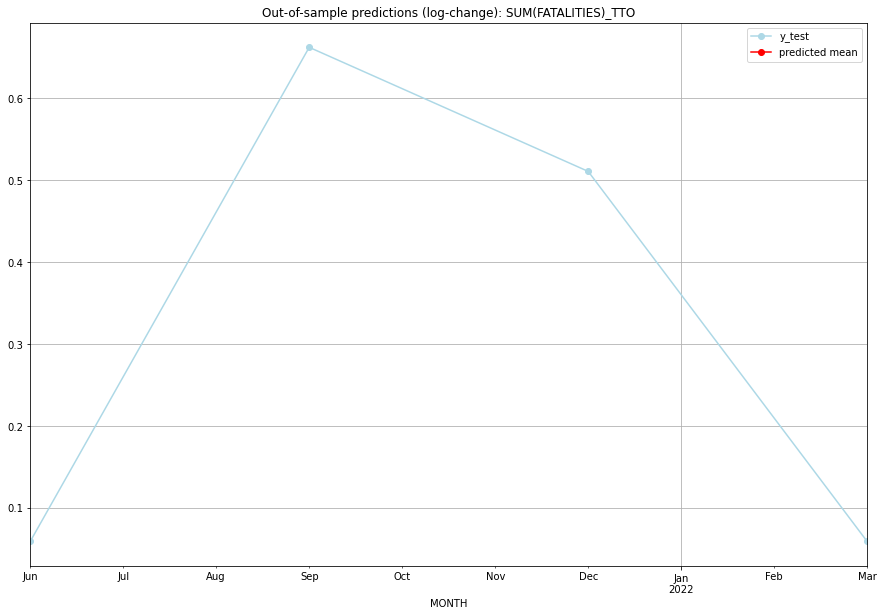

TADDA: nan
Evaluation finished.
Model Prediction failed --> Prediction with Naive Model 


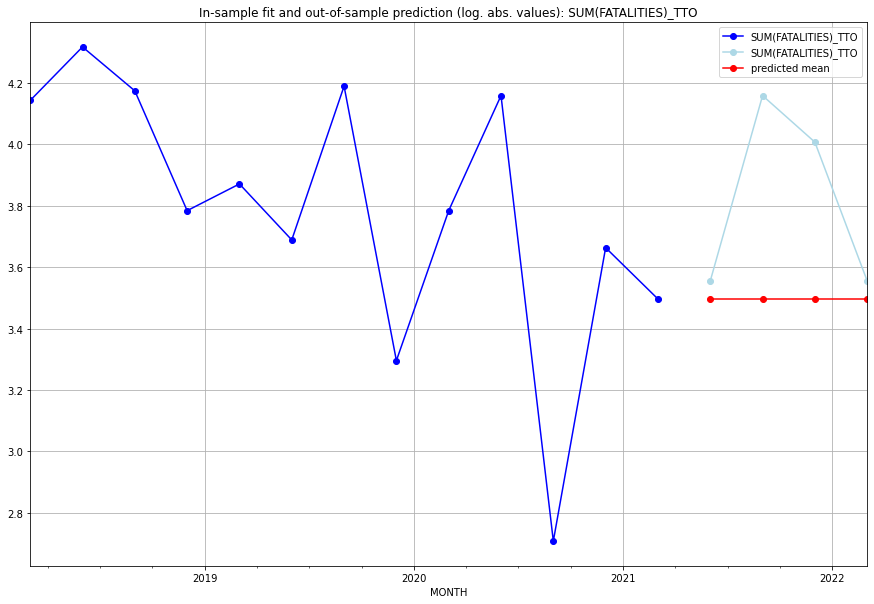

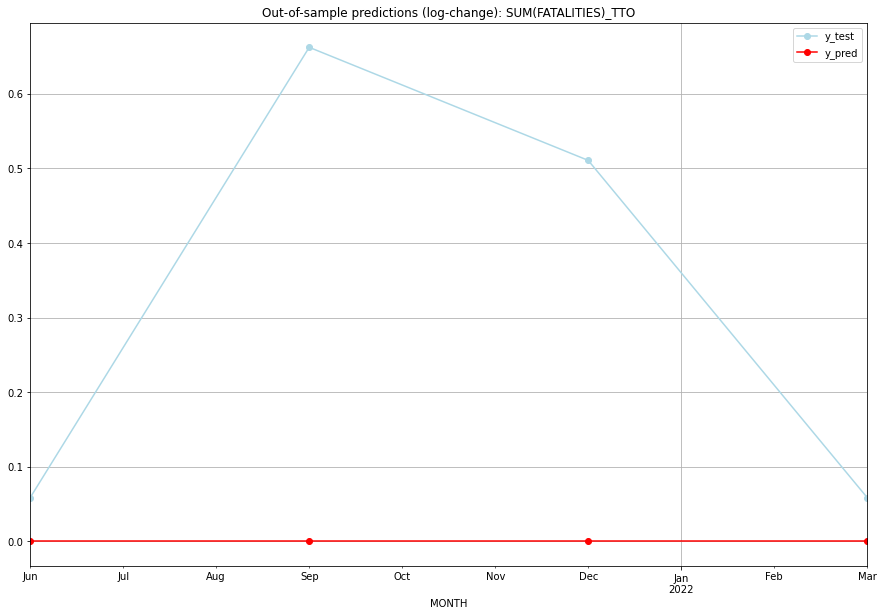

TADDA: 0.32272053642626264
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  3.496508    3.555348           0.0        0.058841   TTO   
1 2021-07-01  3.496508    4.158883           0.0        0.662376   TTO   
2 2021-10-01  3.496508    4.007333           0.0        0.510826   TTO   
3 2022-01-01  3.496508    3.555348           0.0        0.058841   TTO   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:23
######## TUN (209/234) #########
0
Neighbor countries: []
Getting Data for TUN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 95)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [3, (1, 1, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.2529374382502437, 'fold_results': [0.2529374382502437]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_TUN   No. Observations:                   96
Model:                SARIMAX(1, 1, 0)   Log Likelihood                -118.927
Date:                 Sat, 03 Sep 2022   AIC                            247.855
Time:                         20:01:40   BIC                            260.624
Sample:                     04-30-1997   HQIC                           253.015
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4862      0.191      2.545      

<Figure size 432x288 with 0 Axes>

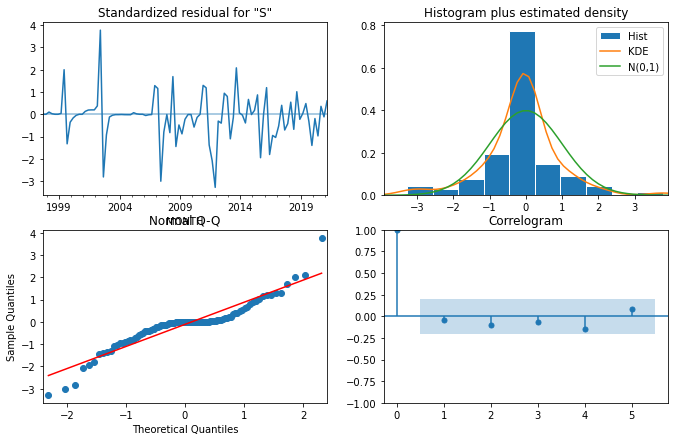

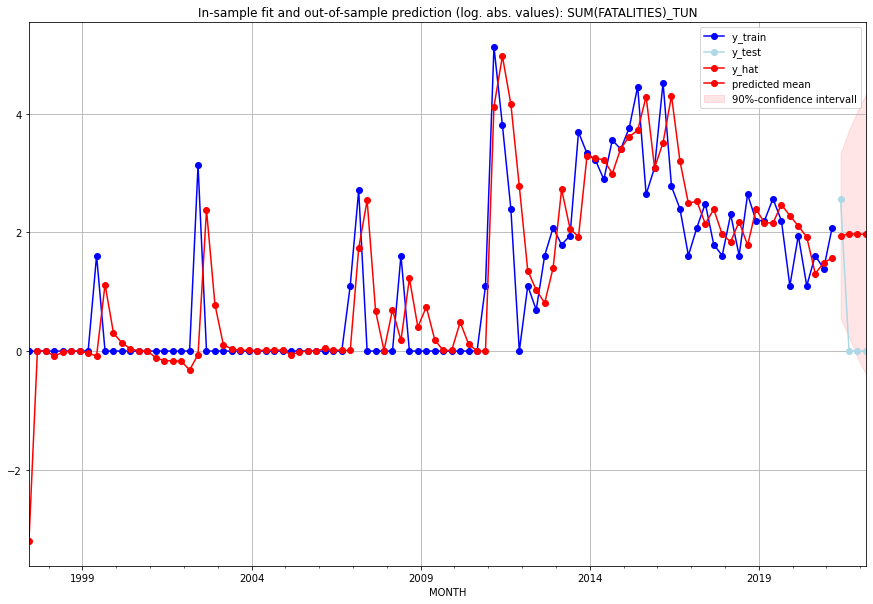

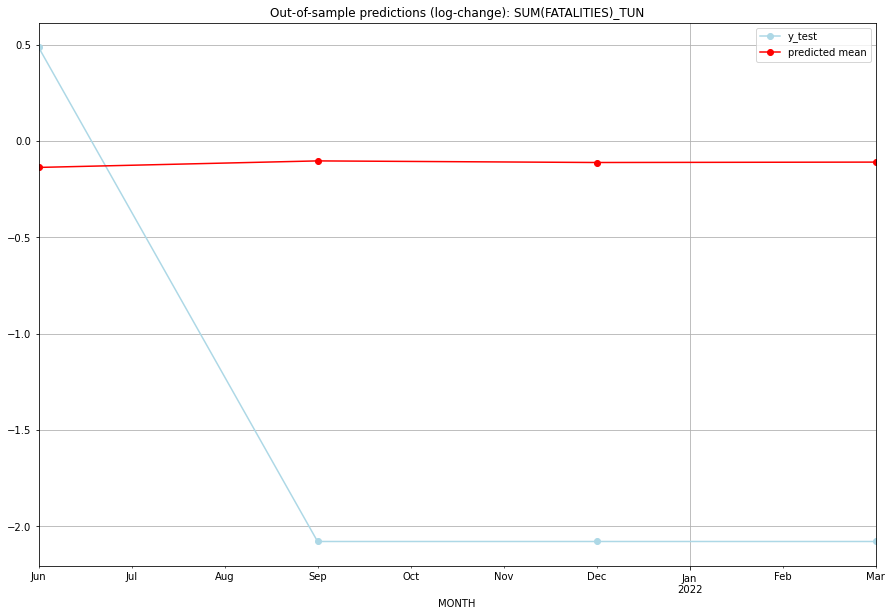

TADDA: 1.6682250310782647
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  5.969407        12.0     -0.137911        0.485508   TUN   
1 2021-07-01  6.209381         0.0     -0.104058       -2.079442   TUN   
2 2021-10-01  6.149721         0.0     -0.112368       -2.079442   TUN   
3 2022-01-01  6.164320         0.0     -0.110328       -2.079442   TUN   

                                          PARAMETERS  
0  {'params': [3, (1, 1, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [3, (1, 1, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [3, (1, 1, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [3, (1, 1, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:25
######## TUR (210/234) #########
0
Neighbor countries: []
Getting Data for TUR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (25, 96)
y: (25, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU core

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (3, 1, 2), (0, 0, 0, 0), 'n'], 'cv_score': 0.47932682624183254, 'fold_results': [0.47932682624183254]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_TUR   No. Observations:                   21
Model:                SARIMAX(3, 1, 2)   Log Likelihood                 -13.278
Date:                 Sat, 03 Sep 2022   AIC                             38.555
Time:                         20:02:06   BIC                             44.530
Sample:                     01-31-2016   HQIC                            39.722
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8058      0.445     -1.811    

<Figure size 432x288 with 0 Axes>

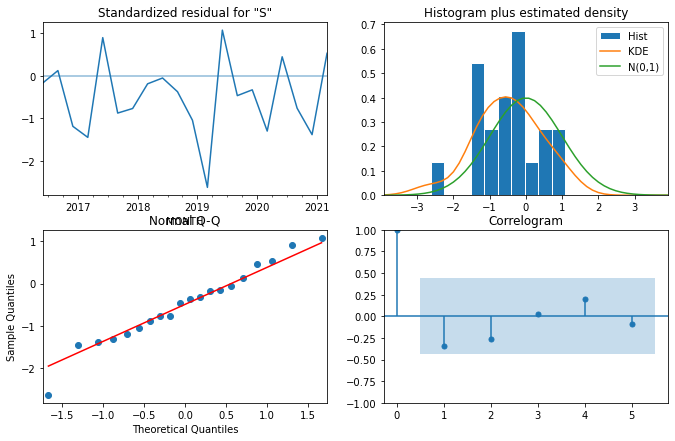

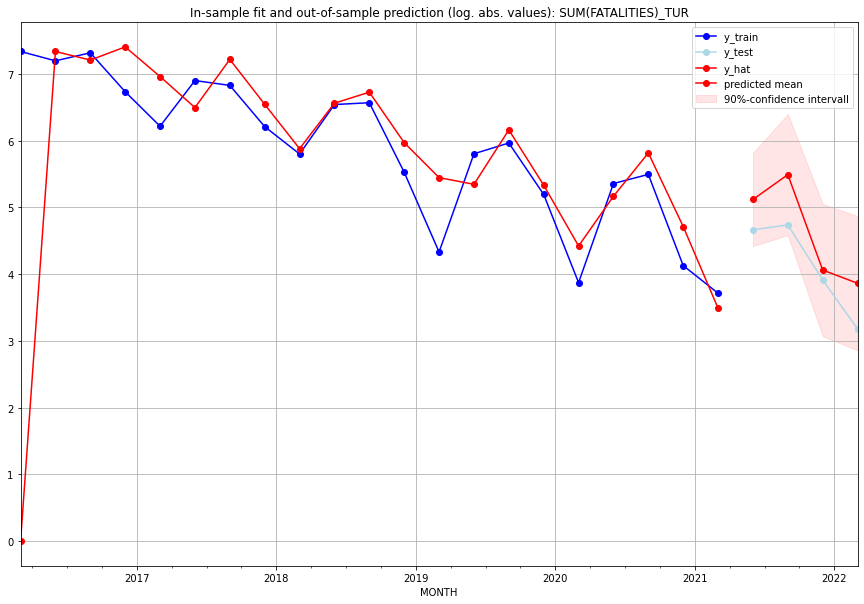

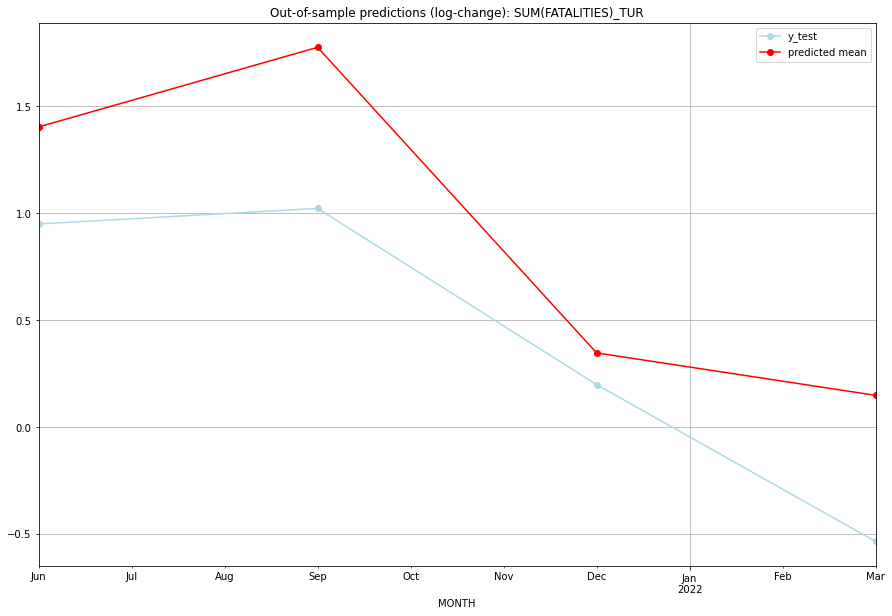

TADDA: 0.5469125259557026
Evaluation finished.
       MONTH    FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  165.875746       105.0      1.403677        0.949867   TUR   
1 2021-07-01  241.213814       113.0      1.776249        1.022626   TUR   
2 2021-10-01   56.987944        49.0      0.346663        0.198451   TUR   
3 2022-01-01   46.551604        23.0      0.148243       -0.535518   TUR   

                                          PARAMETERS  
0  {'params': [0, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:25
######## TWN (211/234) #########
0
Neighbor countries: []
Getting Data for TWN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 47)
y: (17, 1)
------------------------------------------------
Training started.
y_train is constant. No

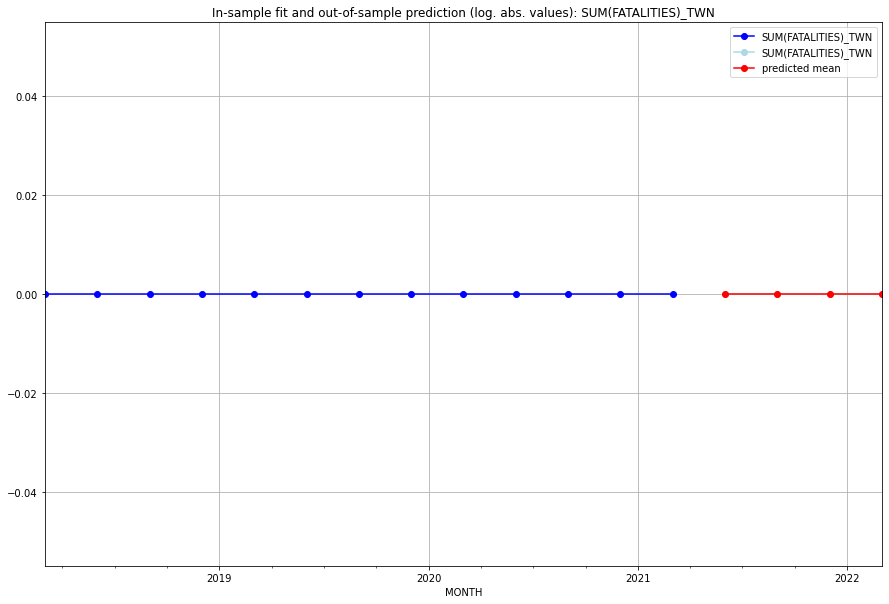

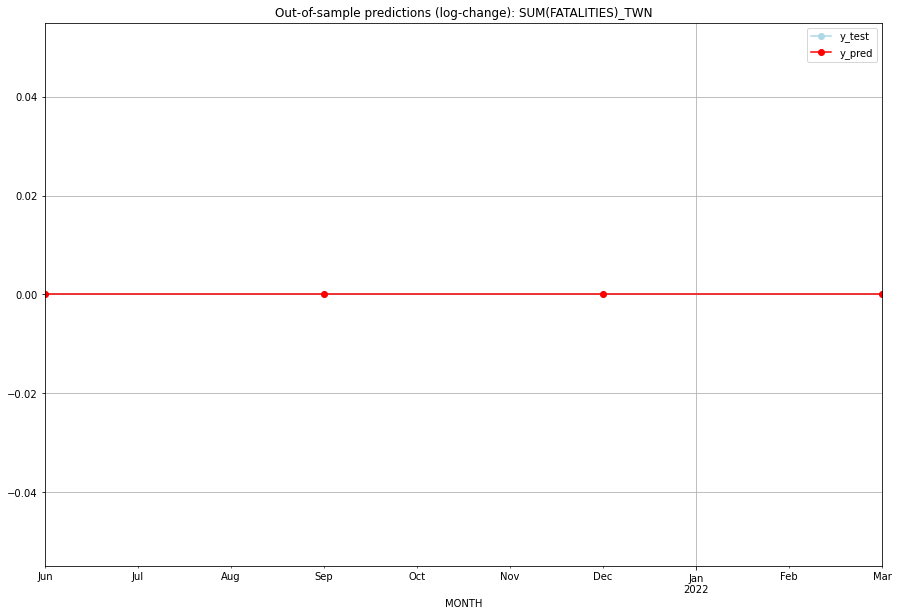

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   TWN   
1 2021-07-01       0.0         0.0           0.0             0.0   TWN   
2 2021-10-01       0.0         0.0           0.0             0.0   TWN   
3 2022-01-01       0.0         0.0           0.0             0.0   TWN   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:04
######## TZA (212/234) #########
0
Neighbor countries: []
Getting Data for TZA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 90)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], 'cv_score': 1.1799223206128104, 'fold_results': [1.1799223206128104]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_TZA   No. Observations:                   96
Model:                SARIMAX(2, 1, 0)   Log Likelihood                -170.865
Date:                 Sat, 03 Sep 2022   AIC                            347.729
Time:                         20:02:33   BIC                            355.391
Sample:                     04-30-1997   HQIC                           350.825
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4704      0.085     -5.525      

<Figure size 432x288 with 0 Axes>

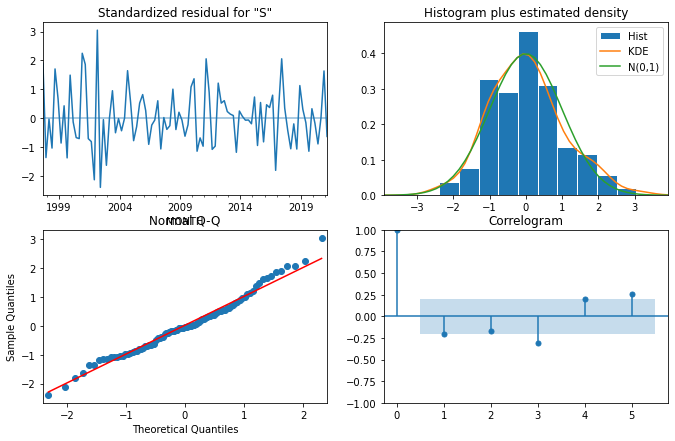

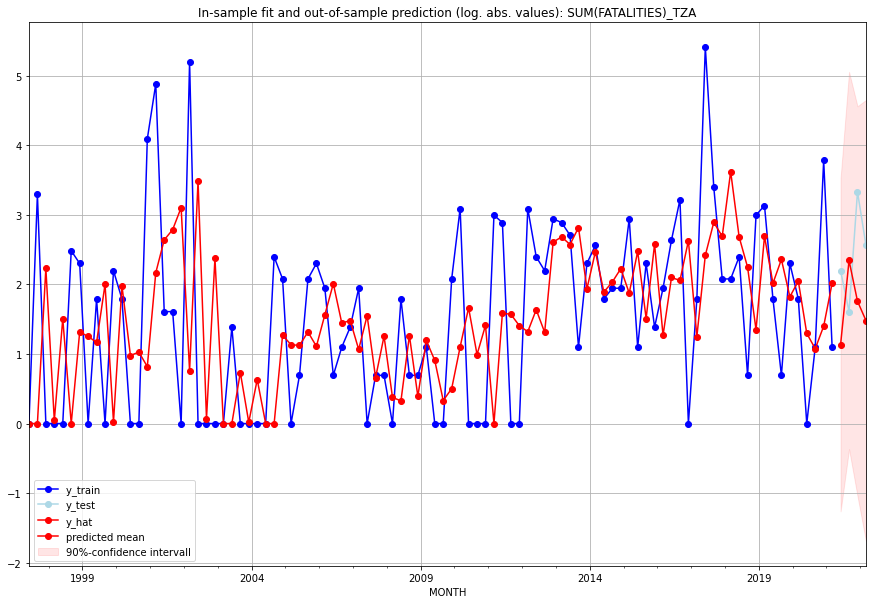

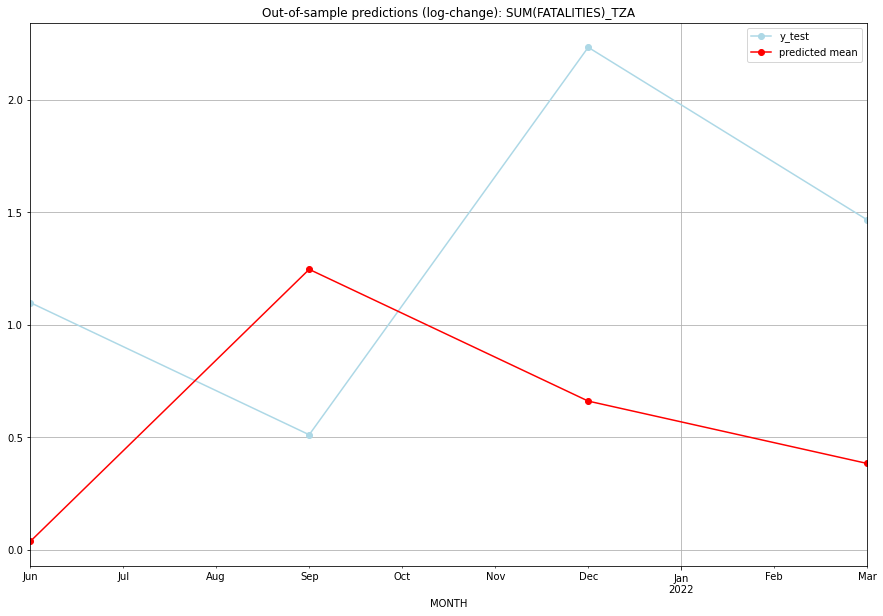

TADDA: 1.113547612667888
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  2.110612         8.0      0.036207        1.098612   TZA   
1 2021-07-01  9.432707         4.0      1.246333        0.510826   TZA   
2 2021-10-01  4.807359        27.0      0.660514        2.233592   TZA   
3 2022-01-01  3.400643        12.0      0.383138        1.466337   TZA   

                                          PARAMETERS  
0  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:24
######## UGA (213/234) #########
0
Neighbor countries: []
Getting Data for UGA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 92)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cor

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [2, (0, 1, 2), (0, 0, 0, 0), 'n'], 'cv_score': 0.5589945385602874, 'fold_results': [0.5589945385602874]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_UGA   No. Observations:                   96
Model:                SARIMAX(0, 1, 2)   Log Likelihood                -133.803
Date:                 Sat, 03 Sep 2022   AIC                            277.606
Time:                         20:03:00   BIC                            290.376
Sample:                     04-30-1997   HQIC                           282.766
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0796      0.151     -0.528      

<Figure size 432x288 with 0 Axes>

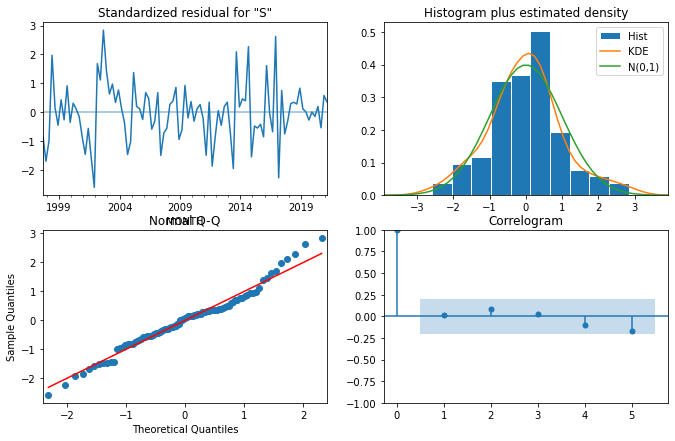

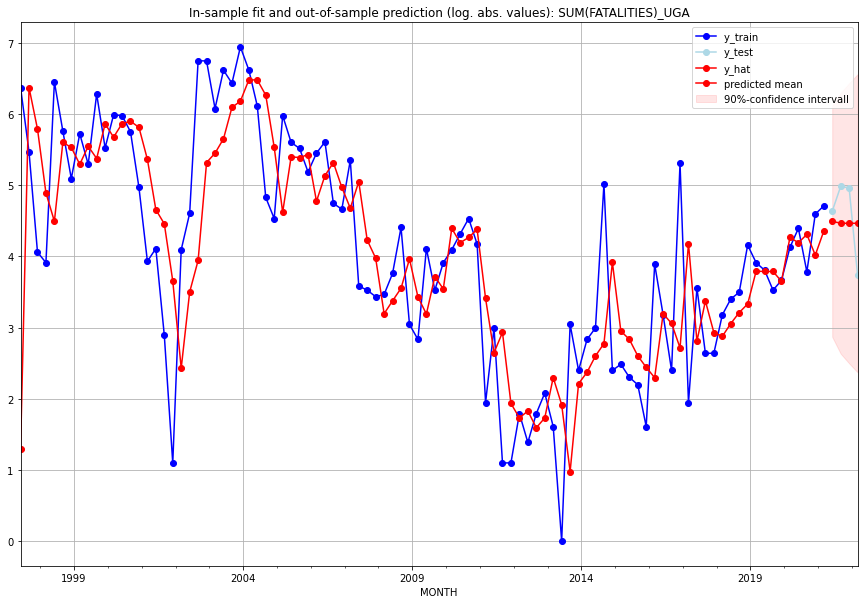

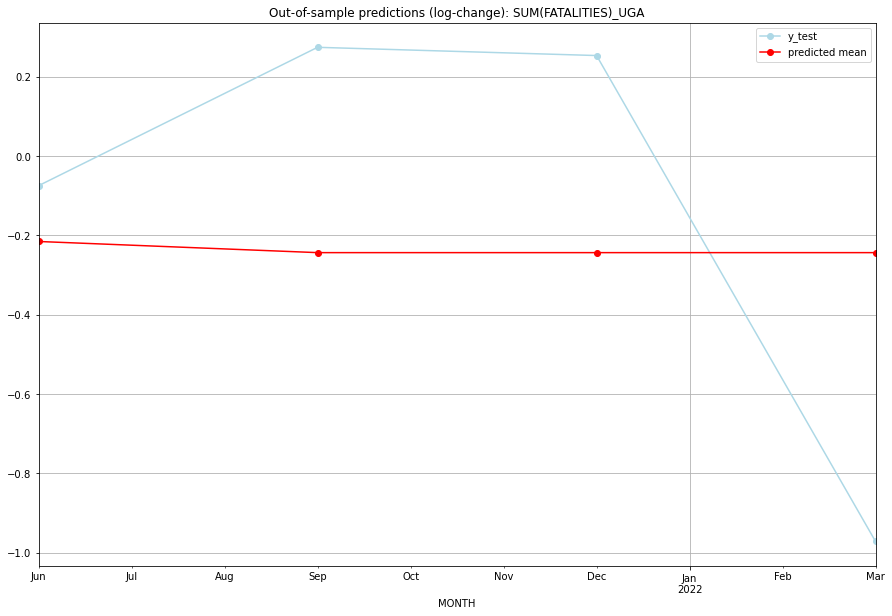

TADDA: 0.5926713057596129
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  88.484058       102.0     -0.215470       -0.074801   UGA   
1 2021-07-01  86.002928       145.0     -0.243588        0.274076   UGA   
2 2021-10-01  86.002928       142.0     -0.243588        0.253314   UGA   
3 2022-01-01  86.002928        41.0     -0.243588       -0.971861   UGA   

                                          PARAMETERS  
0  {'params': [2, (0, 1, 2), (0, 0, 0, 0), 'n'], ...  
1  {'params': [2, (0, 1, 2), (0, 0, 0, 0), 'n'], ...  
2  {'params': [2, (0, 1, 2), (0, 0, 0, 0), 'n'], ...  
3  {'params': [2, (0, 1, 2), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:25
######## UKR (214/234) #########
0
Neighbor countries: []
Getting Data for UKR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 94)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [3, (3, 1, 2), (0, 0, 0, 0), 'n'], 'cv_score': 0.07749629666403435, 'fold_results': [0.07749629666403435]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_UKR   No. Observations:                   13
Model:                SARIMAX(3, 1, 2)   Log Likelihood                  -1.967
Date:                 Sat, 03 Sep 2022   AIC                             21.933
Time:                         20:03:31   BIC                             26.298
Sample:                     01-31-2018   HQIC                            20.318
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0028      1.168     -0.002    

<Figure size 432x288 with 0 Axes>

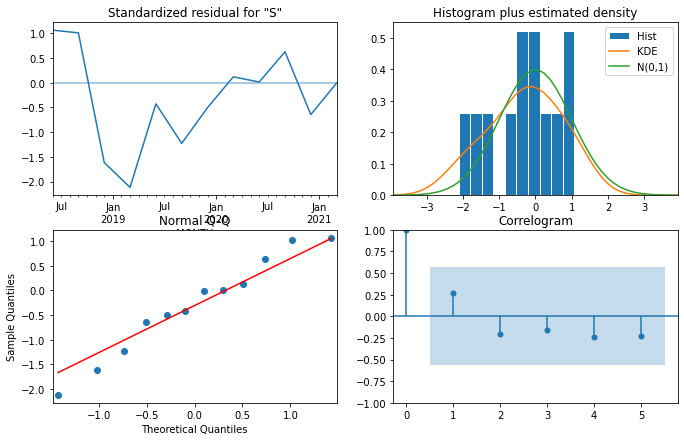

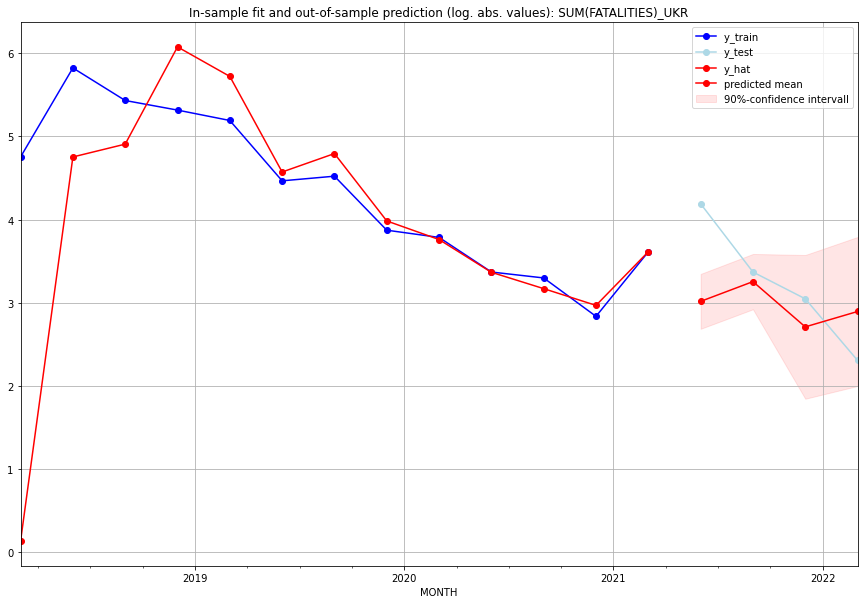

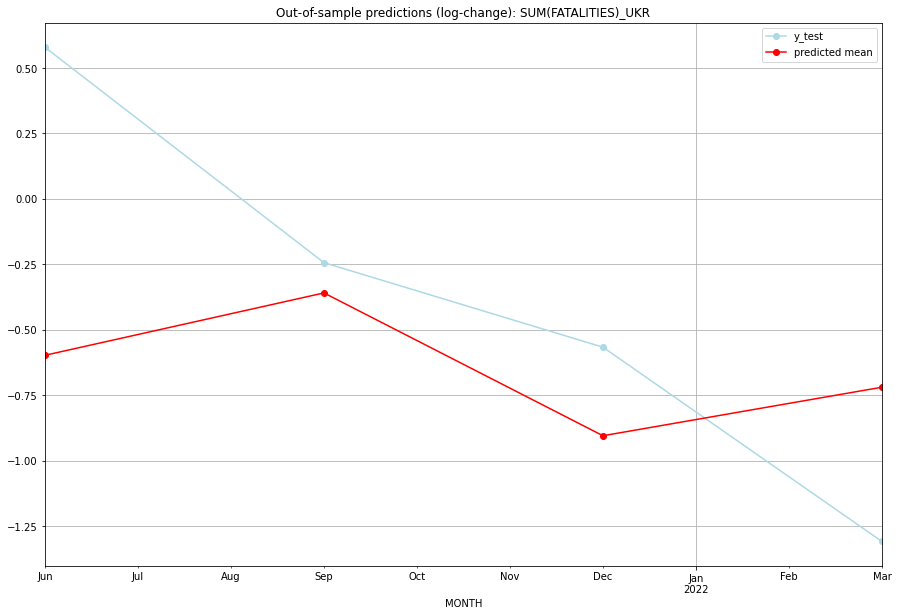

TADDA: 0.7040517949698057
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  19.360231        65.0     -0.597334        0.578737   UKR   
1 2021-07-01  24.835075        28.0     -0.359185       -0.243622   UKR   
2 2021-10-01  13.975279        20.0     -0.904517       -0.566395   UKR   
3 2022-01-01  17.023965         9.0     -0.719216       -1.308333   UKR   

                                          PARAMETERS  
0  {'params': [3, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
1  {'params': [3, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
2  {'params': [3, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
3  {'params': [3, (3, 1, 2), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:33
######## URY (215/234) #########
0
Neighbor countries: []
Getting Data for URY
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 94)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.0, 'fold_results': [0.0]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_URY   No. Observations:                   13
Model:                         SARIMAX   Log Likelihood                  -4.150
Date:                 Sat, 03 Sep 2022   AIC                             10.301
Time:                         20:03:58   BIC                             10.866
Sample:                     01-31-2018   HQIC                            10.185
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1109      0.034      3.291      0.001       0.045       0.177


<Figure size 432x288 with 0 Axes>

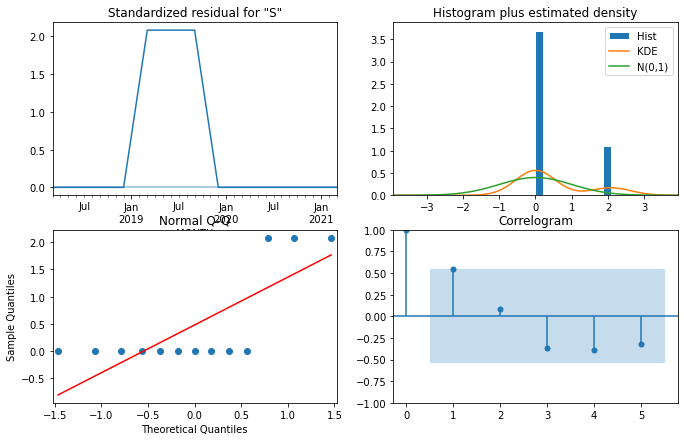

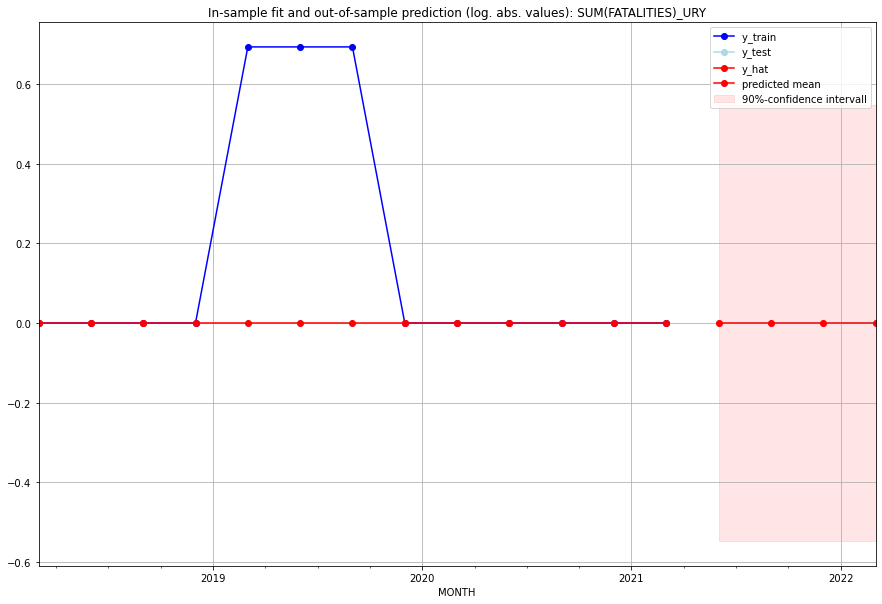

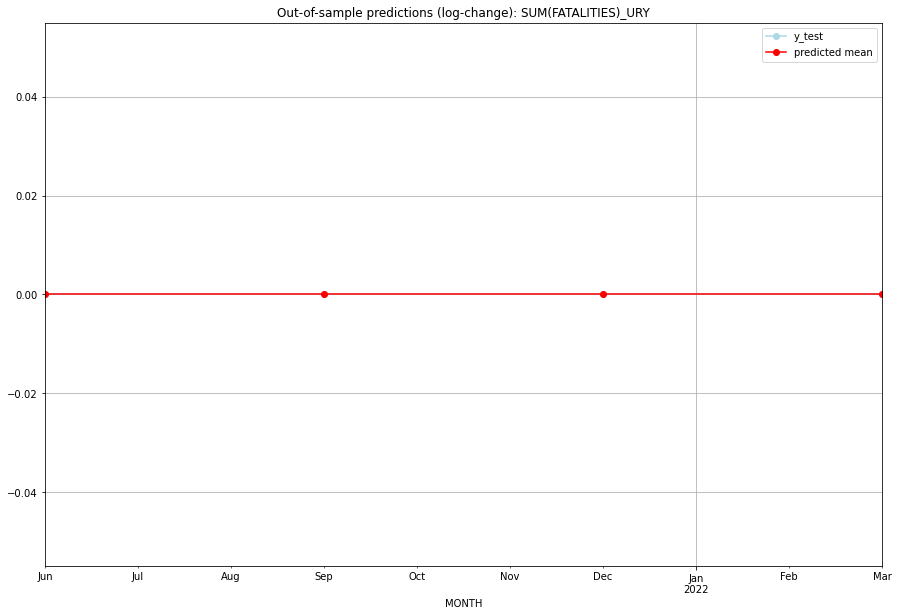

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   URY   
1 2021-07-01       0.0         0.0           0.0             0.0   URY   
2 2021-10-01       0.0         0.0           0.0             0.0   URY   
3 2022-01-01       0.0         0.0           0.0             0.0   URY   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:24
######## USA (216/234) #########
0
Neighbor countries: []
Getting Data for USA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 93)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross v

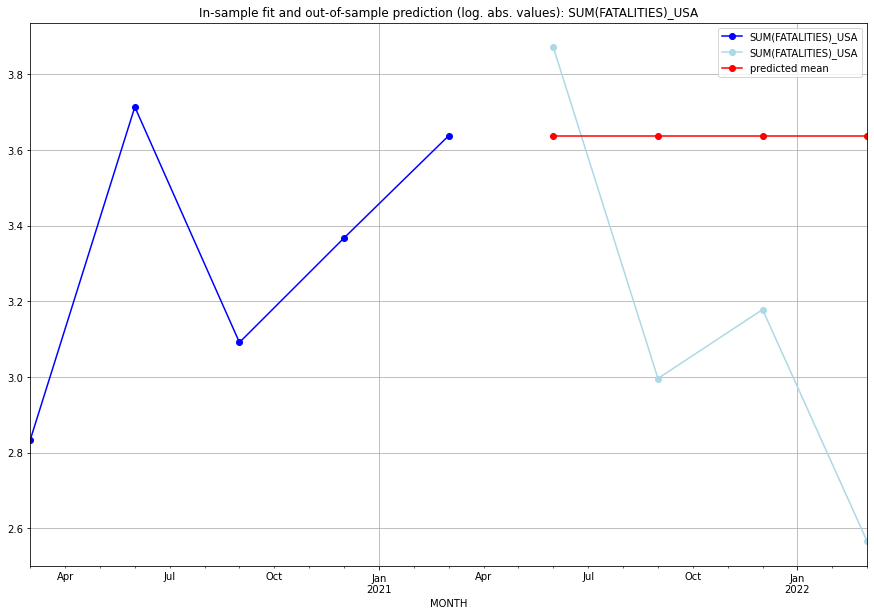

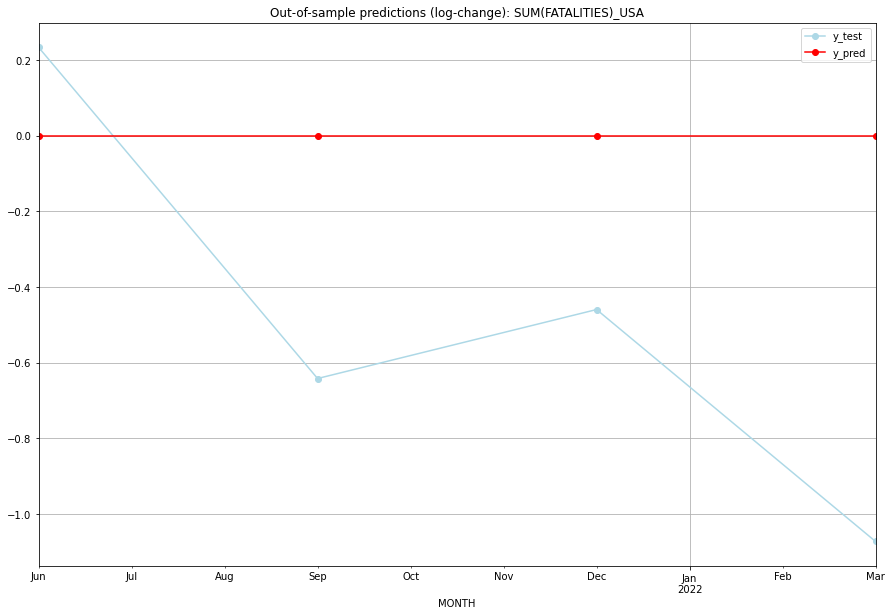

TADDA: 0.6019094672492973
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  3.637586    3.871201           0.0        0.233615   USA   
1 2021-07-01  3.637586    2.995732           0.0       -0.641854   USA   
2 2021-10-01  3.637586    3.178054           0.0       -0.459532   USA   
3 2022-01-01  3.637586    2.564949           0.0       -1.072637   USA   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:02
######## UZB (217/234) #########
0
Neighbor countries: []
Getting Data for UZB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 89)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 0, 3), (0, 0, 0, 0), 'n'], 'cv_score': 0.296770009090902, 'fold_results': [0.296770009090902]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_UZB   No. Observations:                   13
Model:                SARIMAX(2, 0, 3)   Log Likelihood                  -7.577
Date:                 Sat, 03 Sep 2022   AIC                             27.155
Time:                         20:04:27   BIC                             30.545
Sample:                     01-31-2018   HQIC                            26.458
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2261      1.613      0.140      0.

<Figure size 432x288 with 0 Axes>

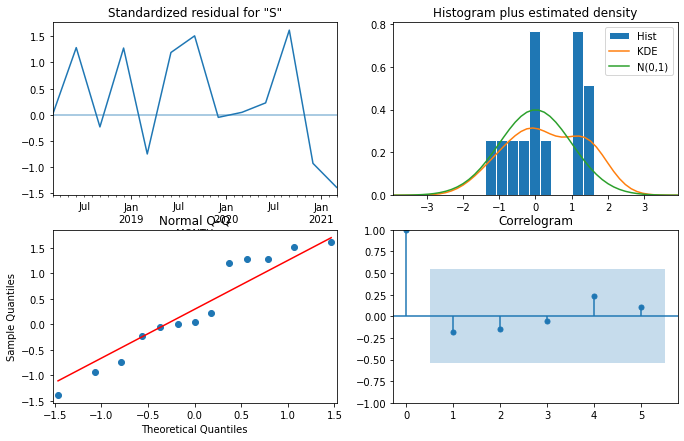

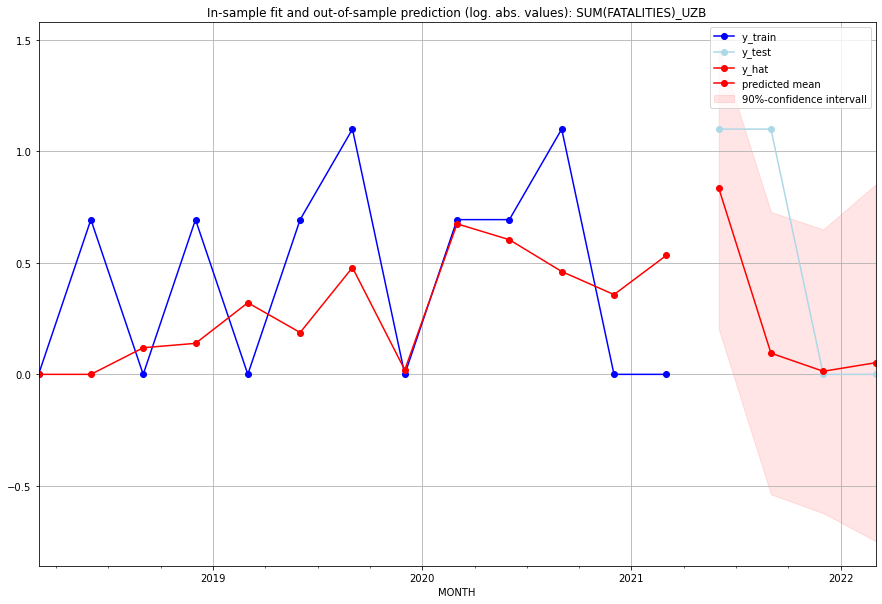

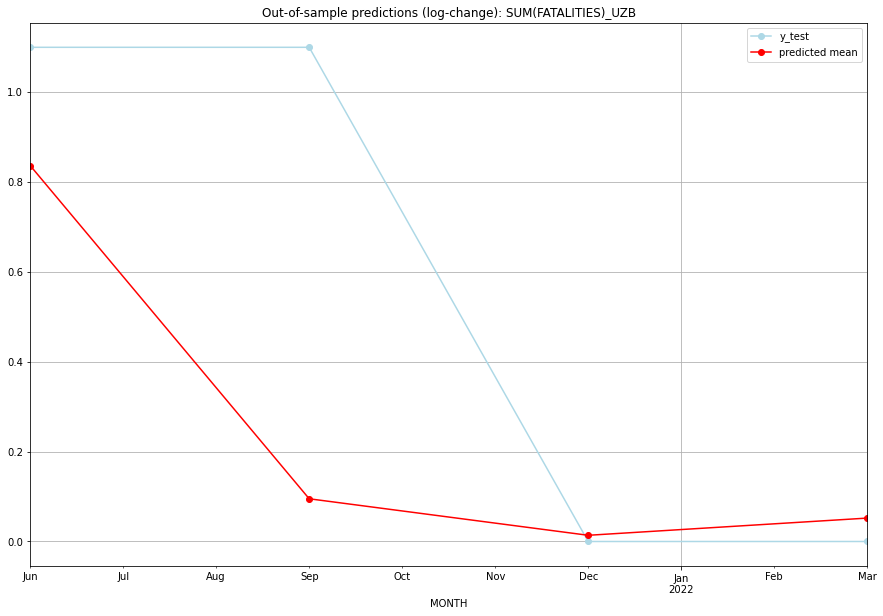

TADDA: 0.33310209721728795
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  1.306386         2.0      0.835682        1.098612   UZB   
1 2021-07-01  0.099603         2.0      0.094949        1.098612   UZB   
2 2021-10-01  0.013880         0.0      0.013785        0.000000   UZB   
3 2022-01-01  0.053408         0.0      0.052030        0.000000   UZB   

                                          PARAMETERS  
0  {'params': [0, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (2, 0, 3), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:26
######## VAT (218/234) #########
0
Neighbor countries: []
Getting Data for VAT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 0)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient d

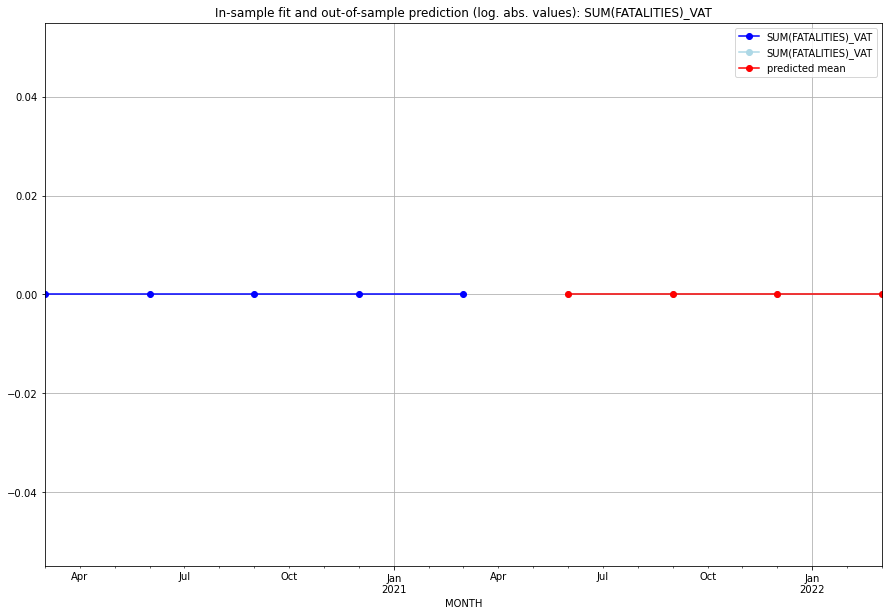

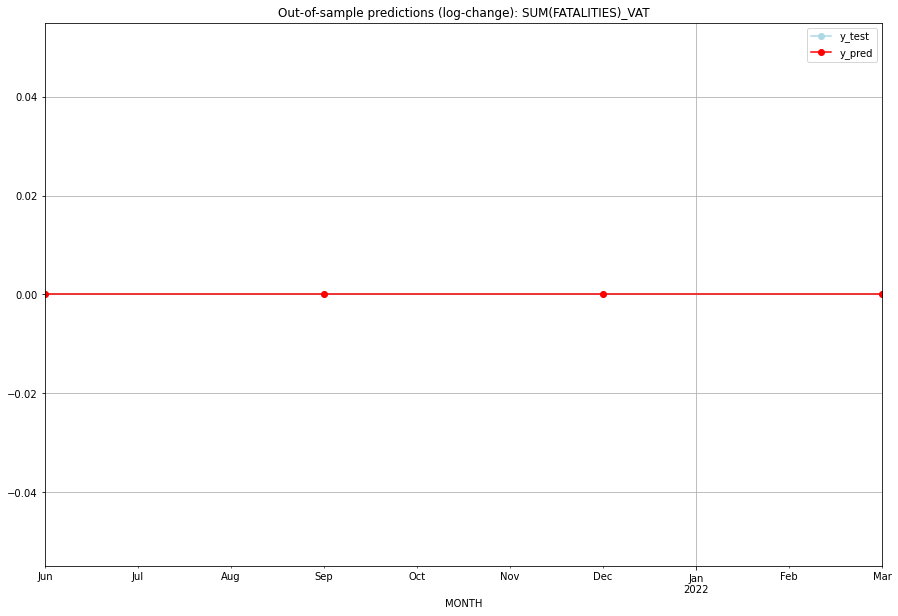

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VAT   
1 2021-07-01       0.0         0.0           0.0             0.0   VAT   
2 2021-10-01       0.0         0.0           0.0             0.0   VAT   
3 2022-01-01       0.0         0.0           0.0             0.0   VAT   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:02
######## VCT (219/234) #########
0
Neighbor countries: []
Getting Data for VCT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 79)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


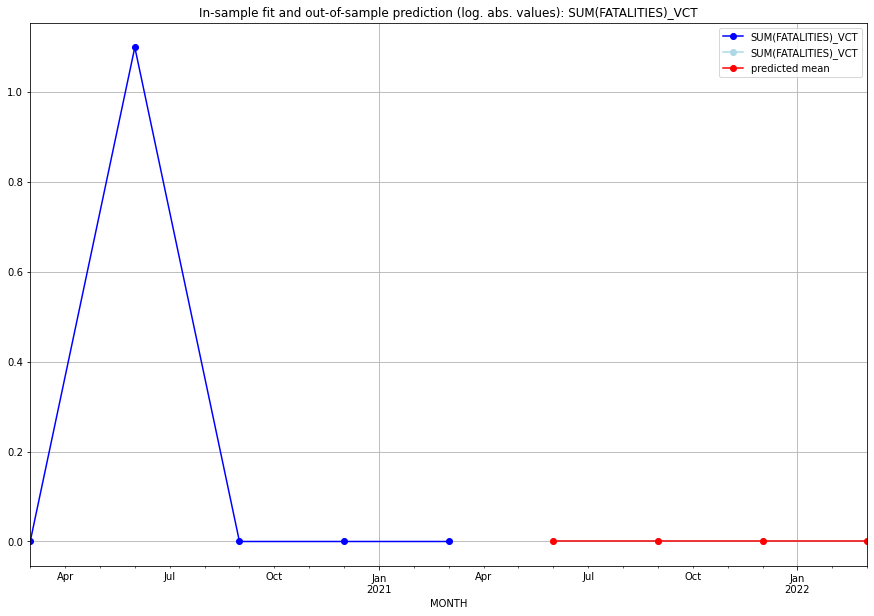

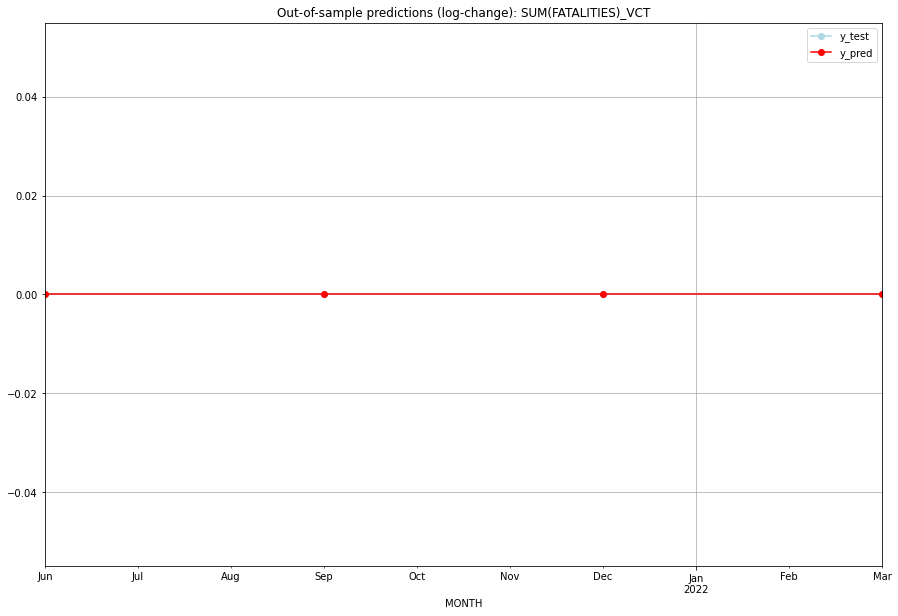

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VCT   
1 2021-07-01       0.0         0.0           0.0             0.0   VCT   
2 2021-10-01       0.0         0.0           0.0             0.0   VCT   
3 2022-01-01       0.0         0.0           0.0             0.0   VCT   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:02
######## VEN (220/234) #########
0
Neighbor countries: []
Getting Data for VEN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 73)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [2, (1, 0, 1), (0, 0, 0, 0), 'n'], 'cv_score': 0.747156035918857, 'fold_results': [0.747156035918857]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_VEN   No. Observations:                   13
Model:                SARIMAX(1, 0, 1)   Log Likelihood                 -11.826
Date:                 Sat, 03 Sep 2022   AIC                             33.653
Time:                         20:04:55   BIC                             36.477
Sample:                     01-31-2018   HQIC                            33.072
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0189      0.257      0.073      0.

<Figure size 432x288 with 0 Axes>

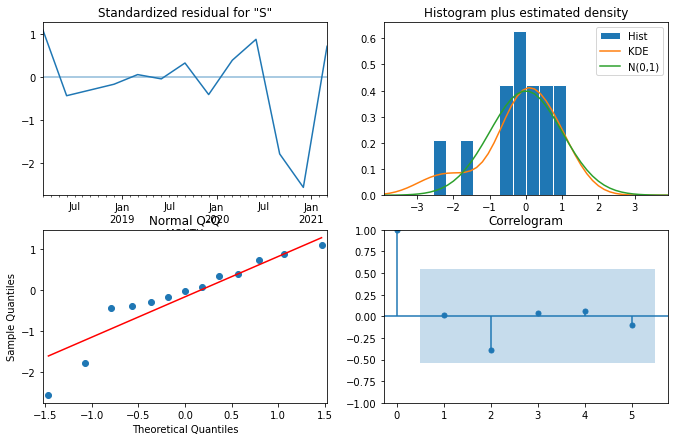

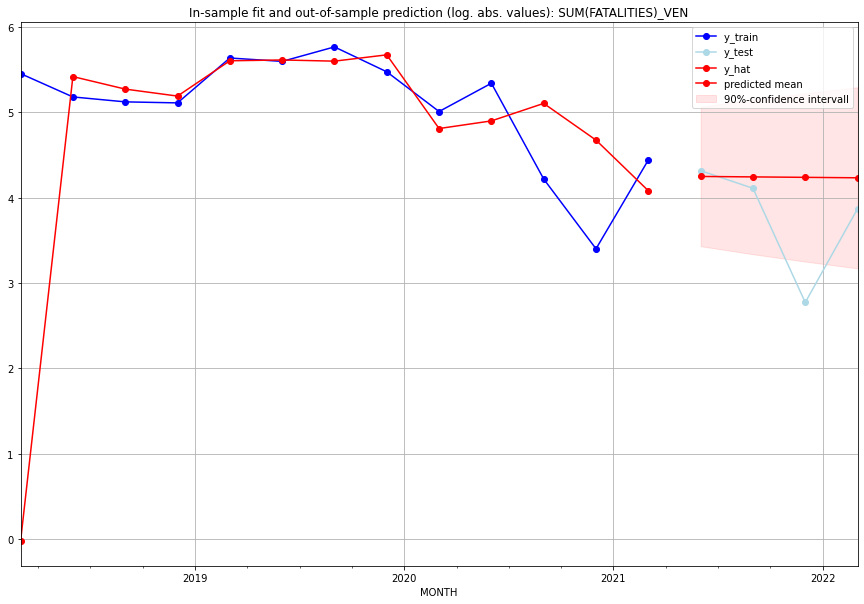

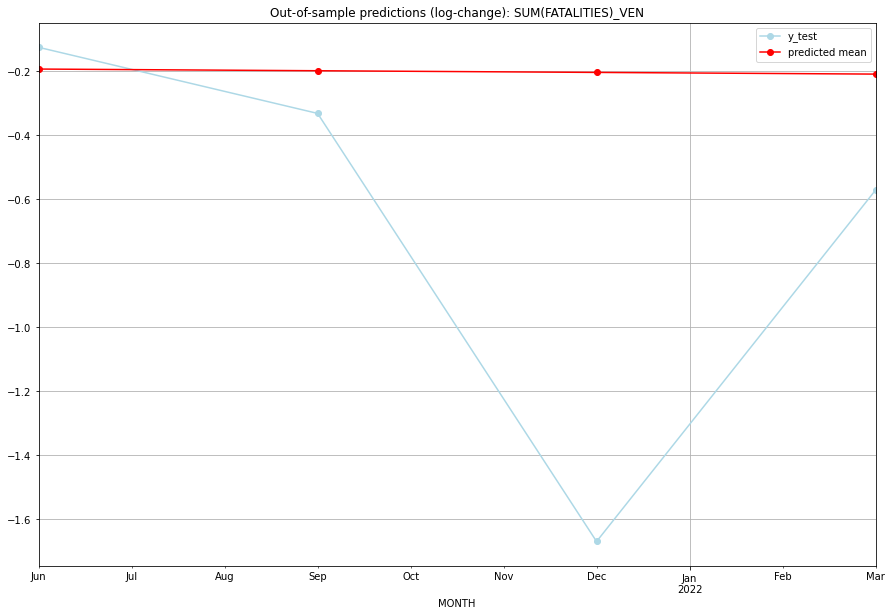

TADDA: 0.5075717141962908
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  69.071764        74.0     -0.193131       -0.125163   VEN   
1 2021-07-01  68.703668        60.0     -0.198398       -0.331777   VEN   
2 2021-10-01  68.337928        15.0     -0.203659       -1.670063   VEN   
3 2022-01-01  67.974526        47.0     -0.208914       -0.571450   VEN   

                                          PARAMETERS  
0  {'params': [2, (1, 0, 1), (0, 0, 0, 0), 'n'], ...  
1  {'params': [2, (1, 0, 1), (0, 0, 0, 0), 'n'], ...  
2  {'params': [2, (1, 0, 1), (0, 0, 0, 0), 'n'], ...  
3  {'params': [2, (1, 0, 1), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:26
######## VIR (221/234) #########
0
Neighbor countries: []
Getting Data for VIR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 25)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insuffici

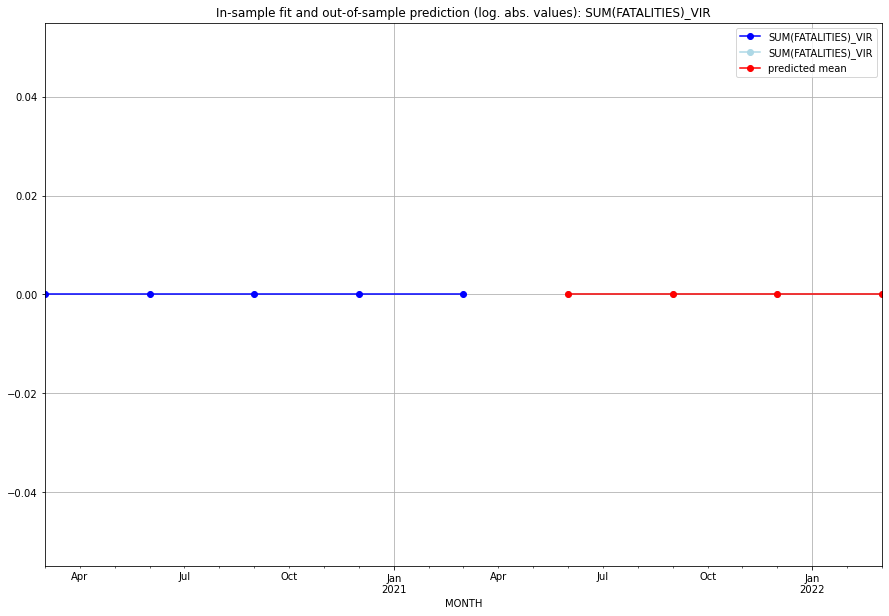

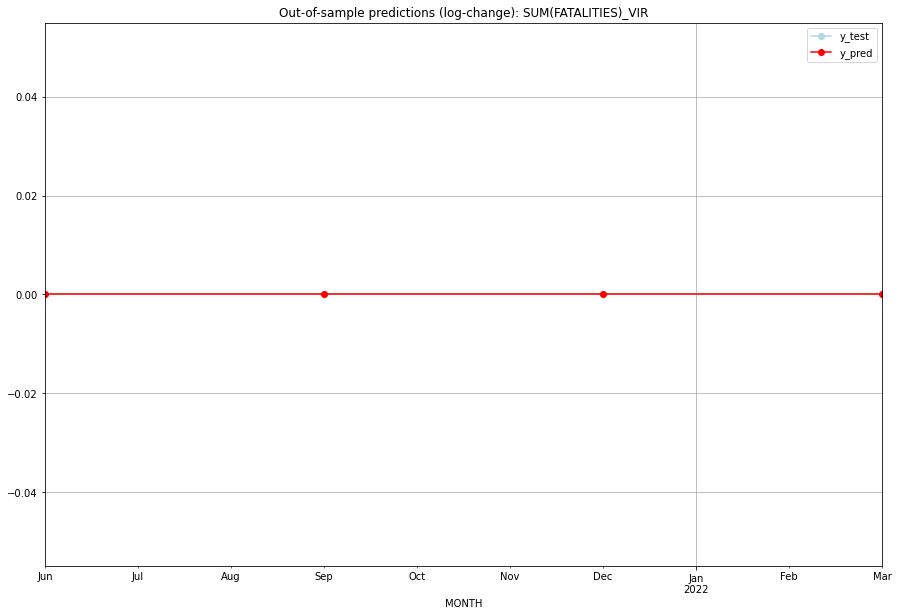

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VIR   
1 2021-07-01       0.0         0.0           0.0             0.0   VIR   
2 2021-10-01       0.0         0.0           0.0             0.0   VIR   
3 2022-01-01       0.0         0.0           0.0             0.0   VIR   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:03
######## VNM (222/234) #########
0
Neighbor countries: []
Getting Data for VNM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (49, 91)
y: (49, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (1, 0, 3), (0, 0, 0, 0), 'n'], 'cv_score': 0.3319046544965909, 'fold_results': [0.3319046544965909]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_VNM   No. Observations:                   45
Model:                SARIMAX(1, 0, 3)   Log Likelihood                 -57.847
Date:                 Sat, 03 Sep 2022   AIC                            125.694
Time:                         20:05:19   BIC                            134.727
Sample:                     01-31-2010   HQIC                           129.061
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9930      0.014     70.290      

<Figure size 432x288 with 0 Axes>

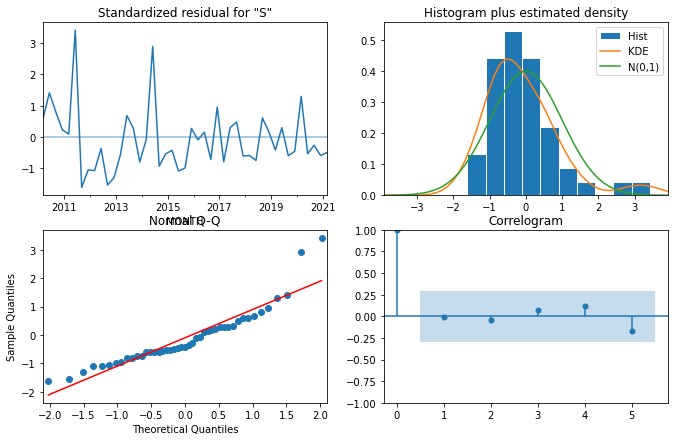

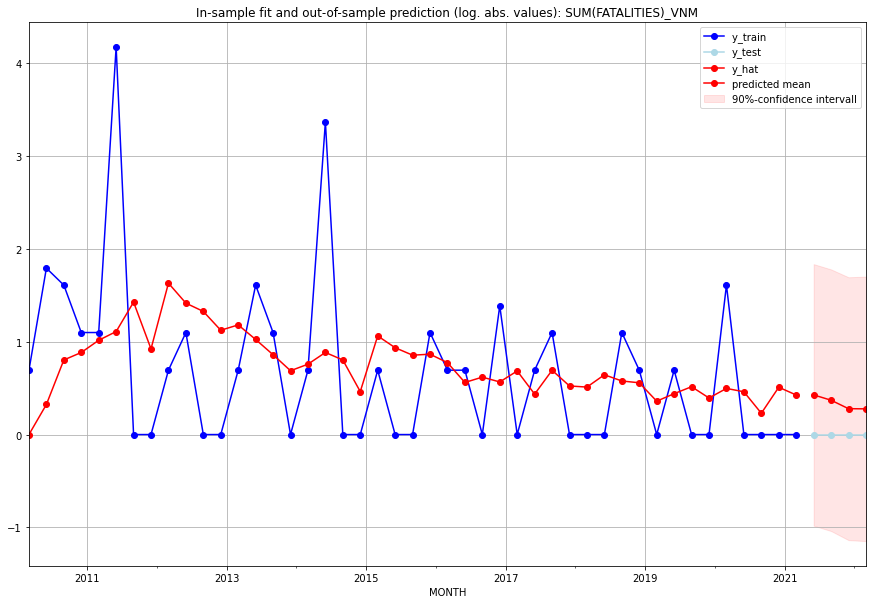

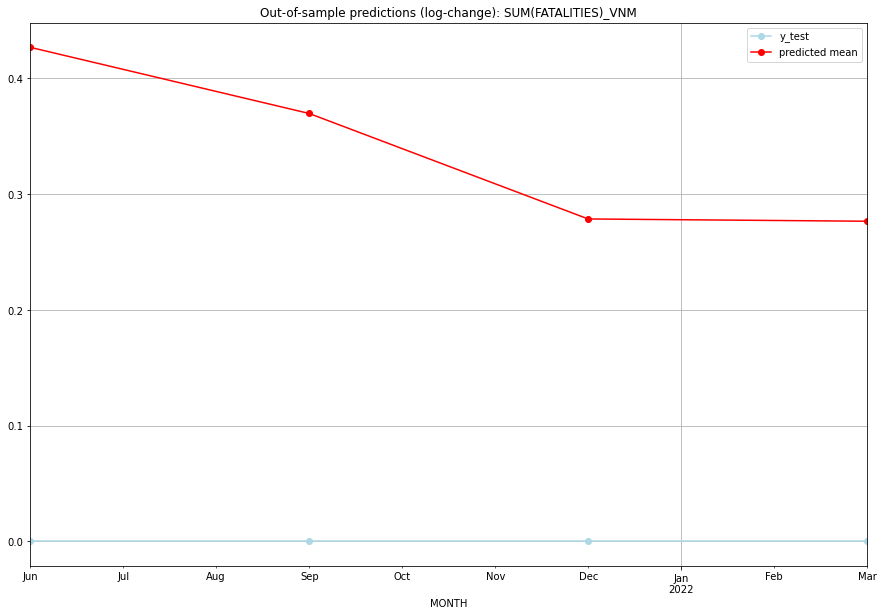

TADDA: 0.33800513790068953
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  0.532553         0.0      0.426935             0.0   VNM   
1 2021-07-01  0.447395         0.0      0.369765             0.0   VNM   
2 2021-10-01  0.321329         0.0      0.278638             0.0   VNM   
3 2022-01-01  0.318747         0.0      0.276682             0.0   VNM   

                                          PARAMETERS  
0  {'params': [0, (1, 0, 3), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (1, 0, 3), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (1, 0, 3), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (1, 0, 3), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:18
######## VUT (223/234) #########
0
Neighbor countries: []
Getting Data for VUT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 79)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient 

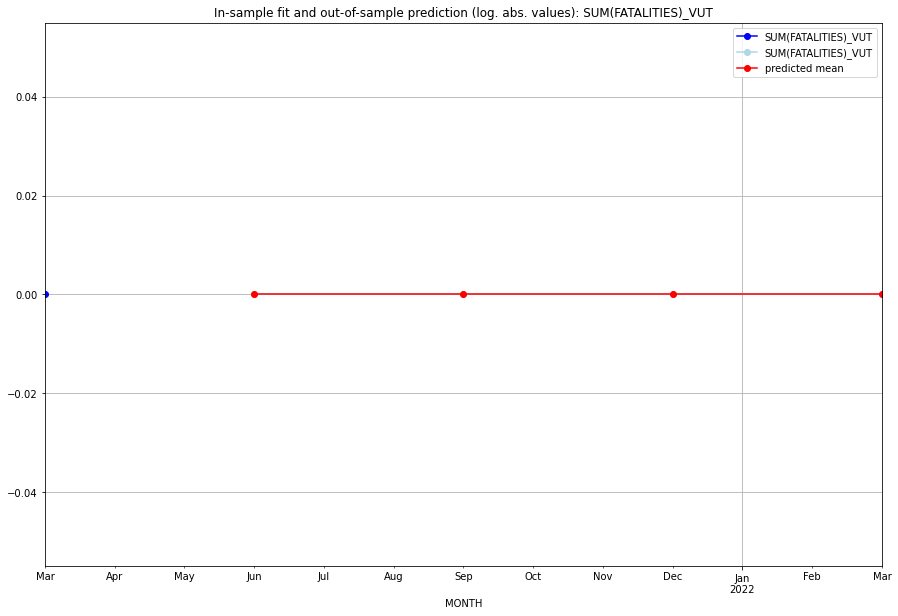

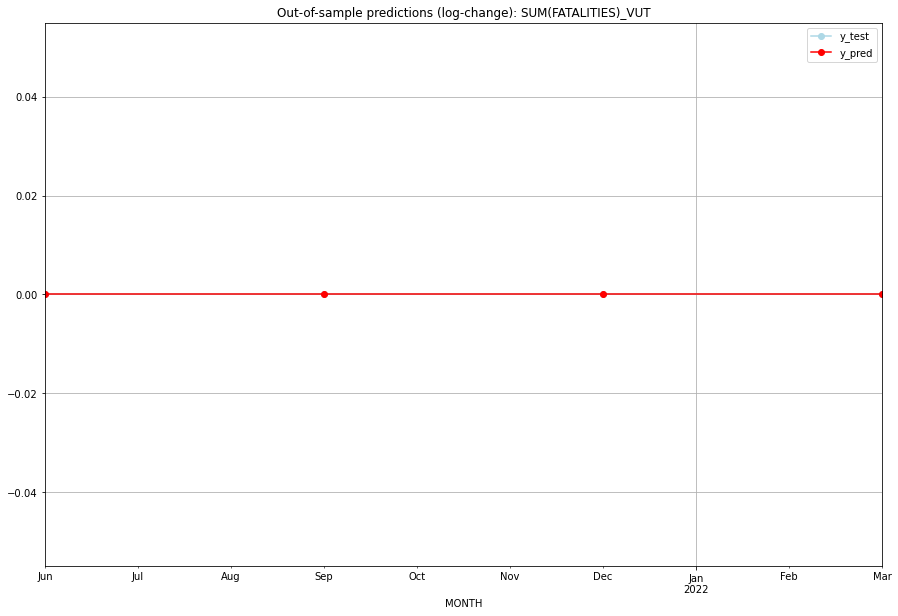

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VUT   
1 2021-07-01       0.0         0.0           0.0             0.0   VUT   
2 2021-10-01       0.0         0.0           0.0             0.0   VUT   
3 2022-01-01       0.0         0.0           0.0             0.0   VUT   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:05
######## WLF (224/234) #########
0
Neighbor countries: []
Getting Data for WLF
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 0)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


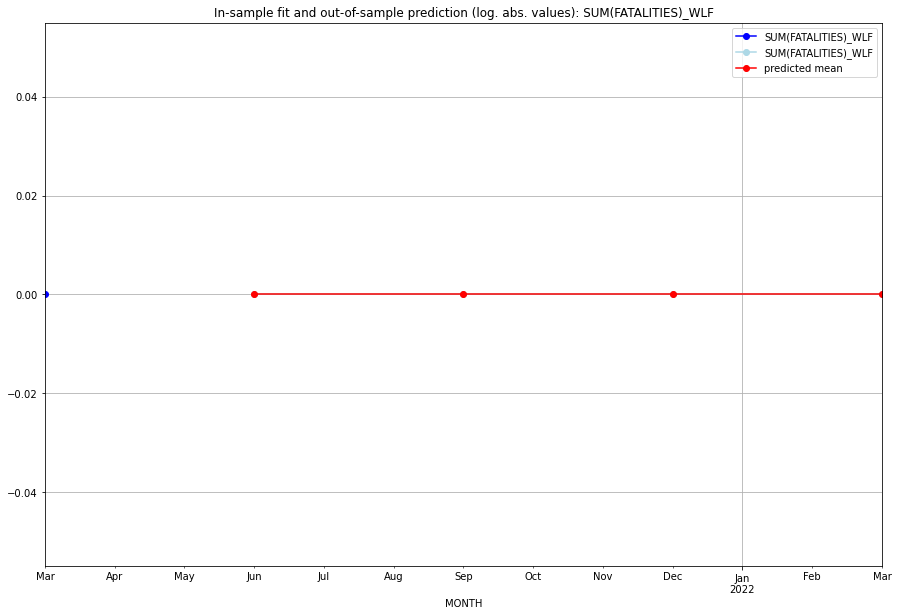

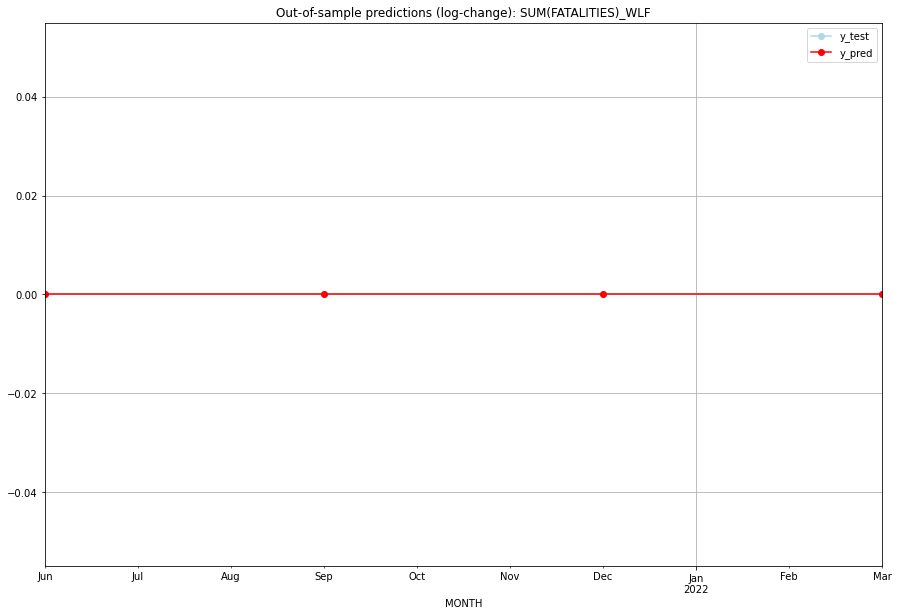

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   WLF   
1 2021-07-01       0.0         0.0           0.0             0.0   WLF   
2 2021-10-01       0.0         0.0           0.0             0.0   WLF   
3 2022-01-01       0.0         0.0           0.0             0.0   WLF   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:02
######## WSM (225/234) #########
0
Neighbor countries: []
Getting Data for WSM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 79)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


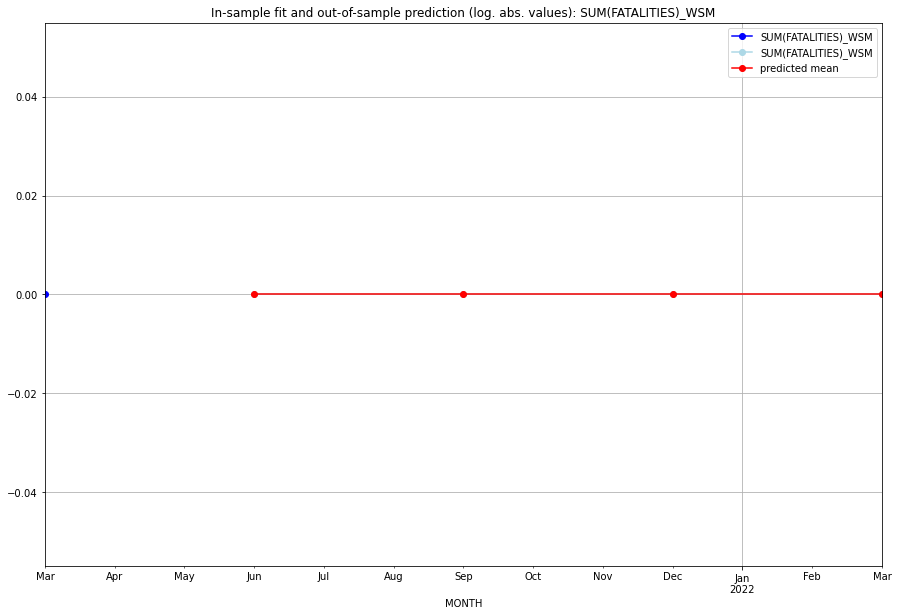

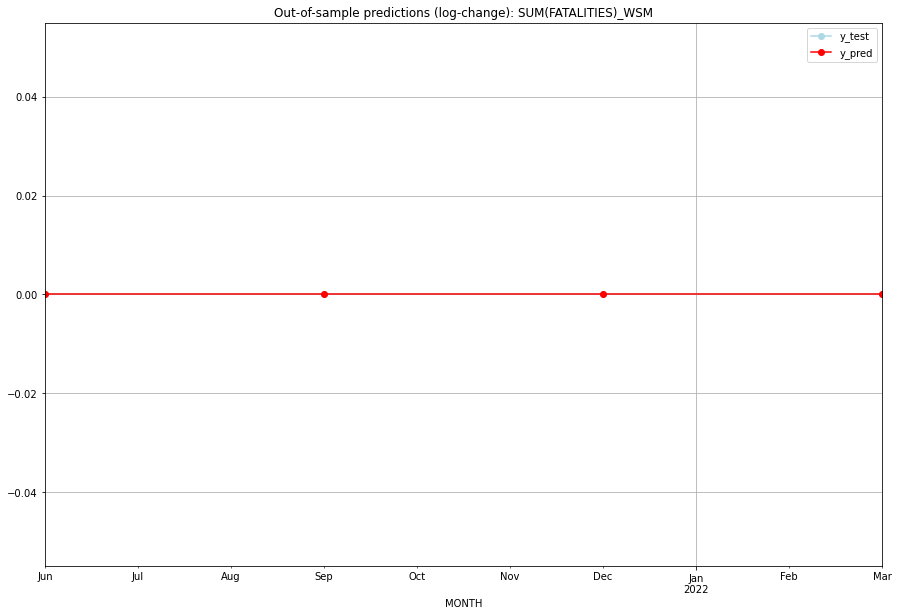

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   WSM   
1 2021-07-01       0.0         0.0           0.0             0.0   WSM   
2 2021-10-01       0.0         0.0           0.0             0.0   WSM   
3 2022-01-01       0.0         0.0           0.0             0.0   WSM   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:02
######## XAR (226/234) #########
0
Neighbor countries: []
Getting Data for XAR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter combinations are tested.


  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.7390342956789828, 'fold_results': [0.7390342956789828]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XAR   No. Observations:                   96
Model:                SARIMAX(2, 1, 0)   Log Likelihood                -166.154
Date:                 Sat, 03 Sep 2022   AIC                            338.309
Time:                         20:05:45   BIC                            345.970
Sample:                     04-30-1997   HQIC                           341.405
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3535      0.085     -4.136      

<Figure size 432x288 with 0 Axes>

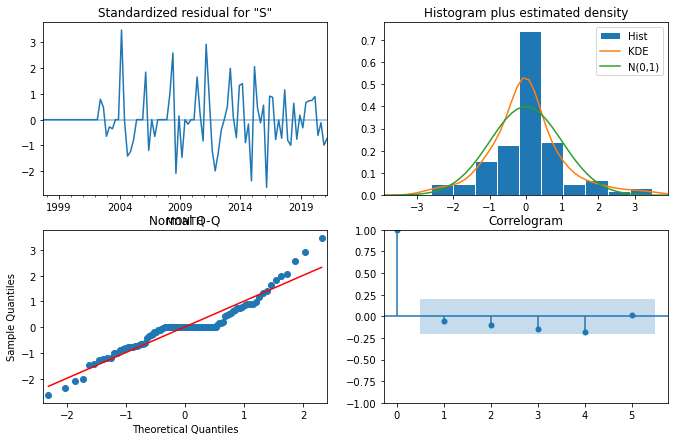

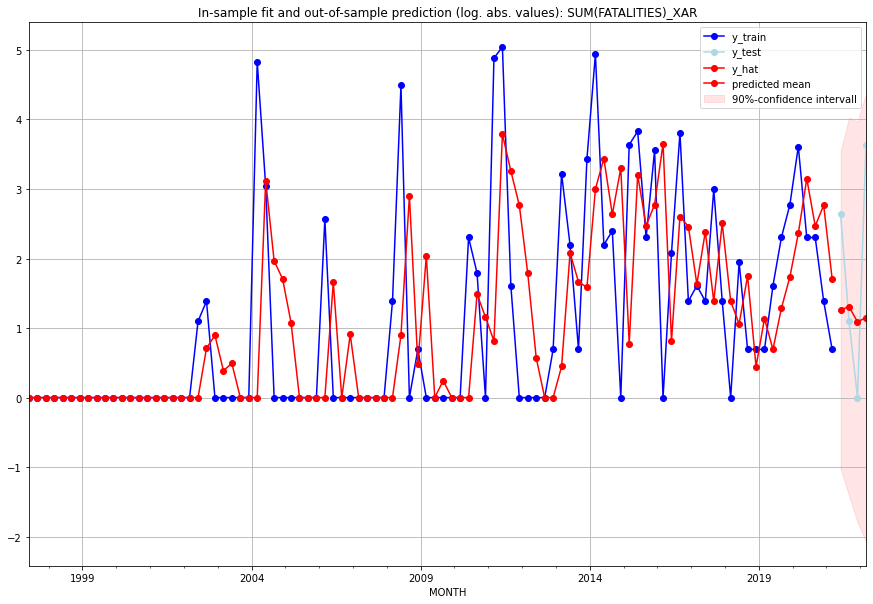

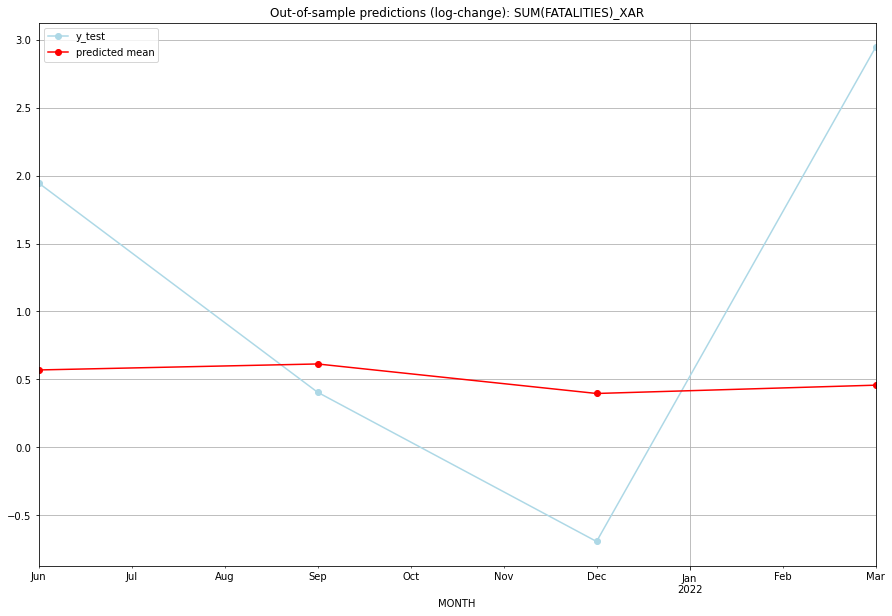

TADDA: 1.3893263574986077
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  2.534757        13.0      0.569497        1.945910   XAR   
1 2021-07-01  2.694144         2.0      0.613602        0.405465   XAR   
2 2021-10-01  1.972795         0.0      0.396356       -0.693147   XAR   
3 2022-01-01  2.160367        37.0      0.457541        2.944439   XAR   

                                          PARAMETERS  
0  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (2, 1, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:16
######## XIT (227/234) #########
0
Neighbor countries: []
Getting Data for XIT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cor

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.0, 'fold_results': [0.0]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XIT   No. Observations:                   96
Model:                         SARIMAX   Log Likelihood                 -14.931
Date:                 Sat, 03 Sep 2022   AIC                             31.863
Time:                         20:06:01   BIC                             34.427
Sample:                     04-30-1997   HQIC                            32.899
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0799      0.002     37.614      0.000       0.076       0.084


<Figure size 432x288 with 0 Axes>

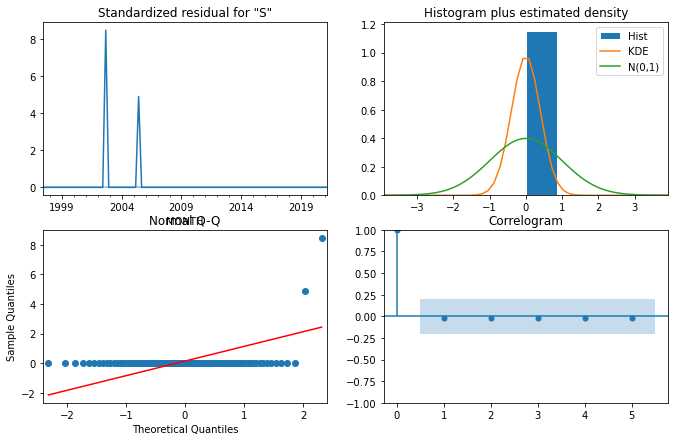

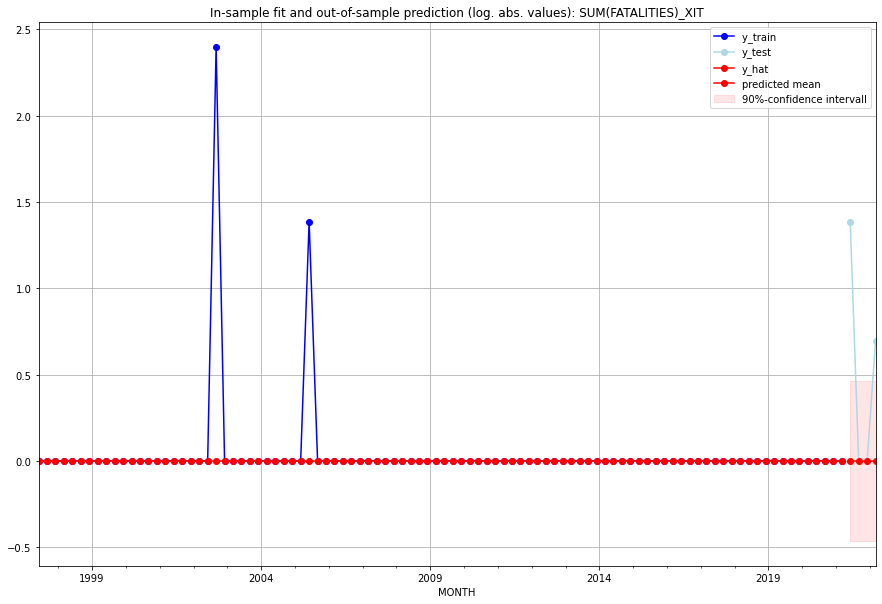

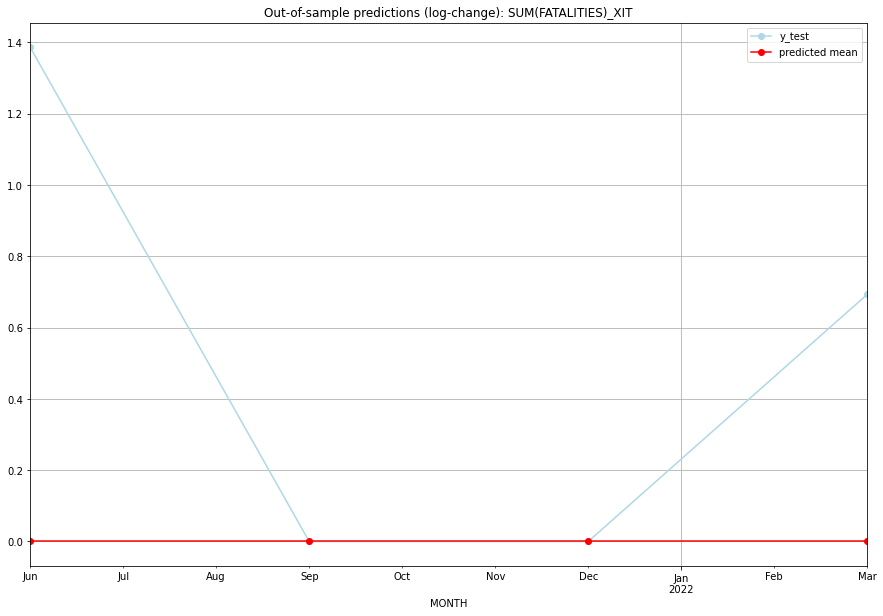

TADDA: 0.5198603854199589
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         3.0           0.0        1.386294   XIT   
1 2021-07-01       0.0         0.0           0.0        0.000000   XIT   
2 2021-10-01       0.0         0.0           0.0        0.000000   XIT   
3 2022-01-01       0.0         1.0           0.0        0.693147   XIT   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:15
######## XKK (228/234) #########
0
Neighbor countries: []
Getting Data for XKK
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cor

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.44793986730701374, 'fold_results': [0.44793986730701374]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XKK   No. Observations:                   96
Model:                         SARIMAX   Log Likelihood                 -90.179
Date:                 Sat, 03 Sep 2022   AIC                            182.359
Time:                         20:06:22   BIC                            184.923
Sample:                     04-30-1997   HQIC                           183.395
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3832      0.012     31.087    

<Figure size 432x288 with 0 Axes>

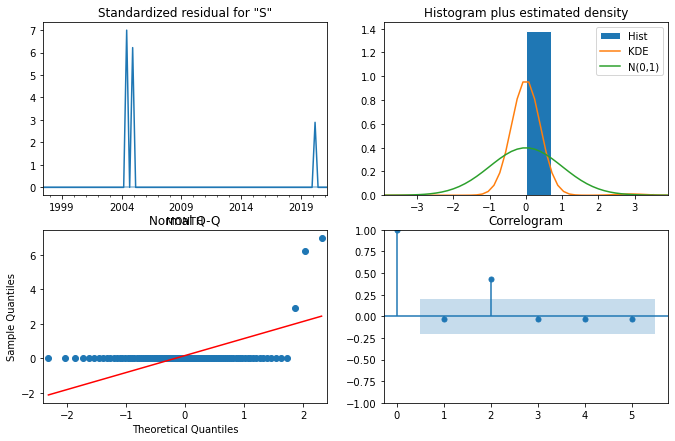

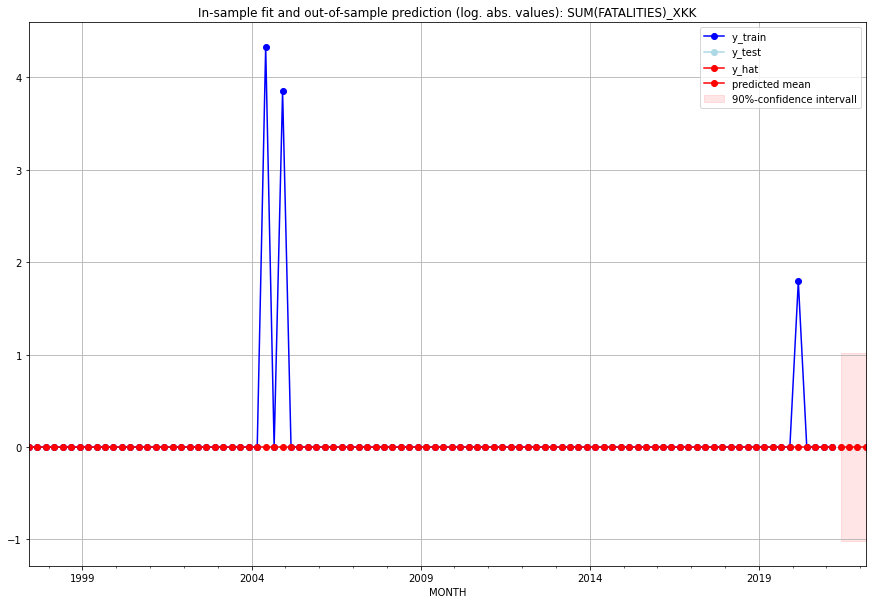

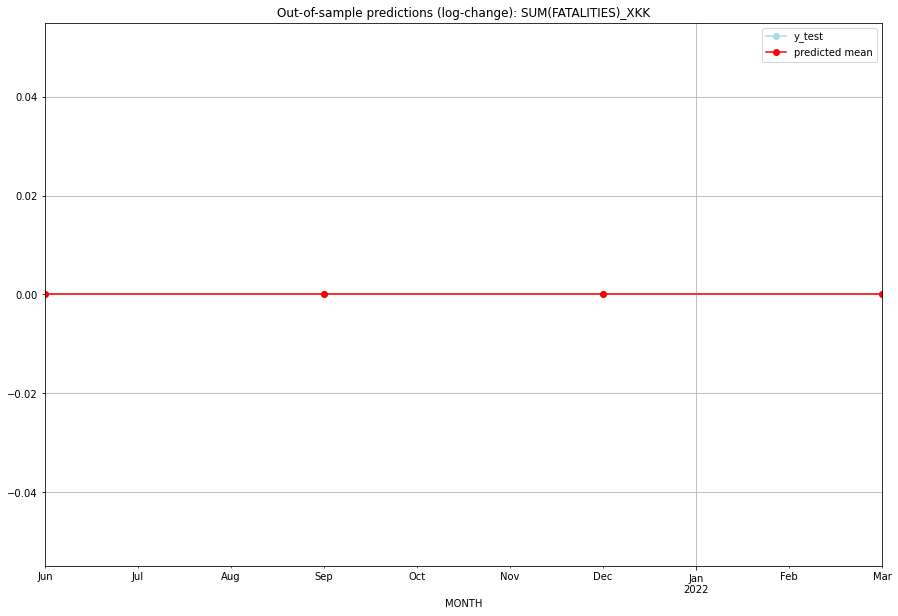

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   XKK   
1 2021-07-01       0.0         0.0           0.0             0.0   XKK   
2 2021-10-01       0.0         0.0           0.0             0.0   XKK   
3 2022-01-01       0.0         0.0           0.0             0.0   XKK   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:17
######## XKO (229/234) #########
0
Neighbor countries: []
Getting Data for XKO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.0, 'fold_results': [0.0]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XKO   No. Observations:                   13
Model:                         SARIMAX   Log Likelihood                  -7.471
Date:                 Sat, 03 Sep 2022   AIC                             16.941
Time:                         20:06:35   BIC                             17.506
Sample:                     01-31-2018   HQIC                            16.825
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1848      0.037      5.048      0.000       0.113       0.257


<Figure size 432x288 with 0 Axes>

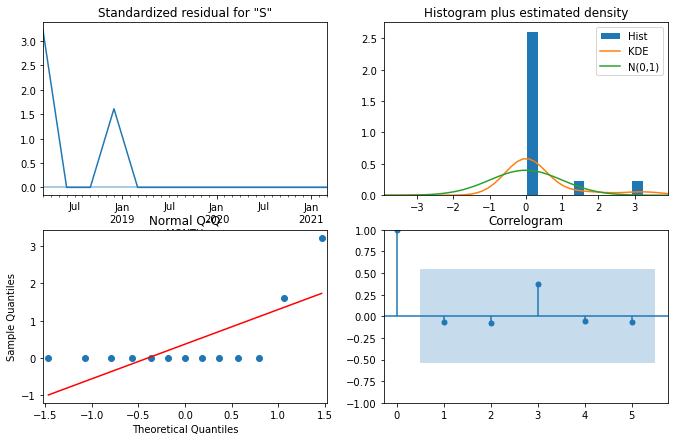

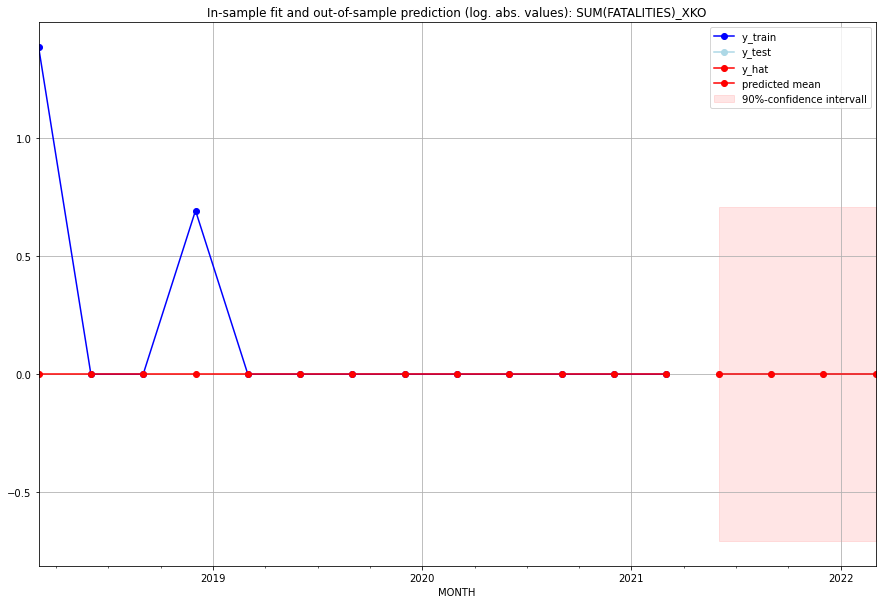

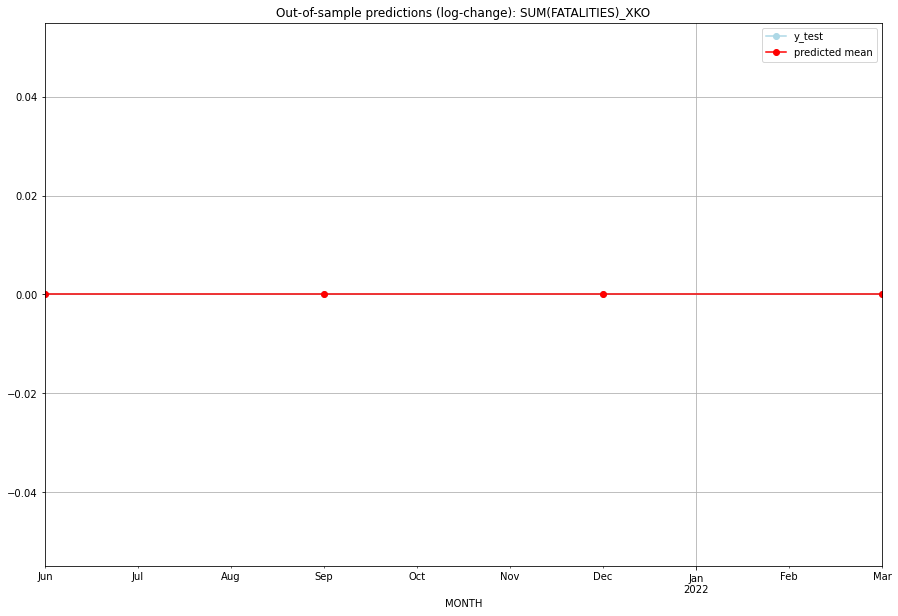

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   XKO   
1 2021-07-01       0.0         0.0           0.0             0.0   XKO   
2 2021-10-01       0.0         0.0           0.0             0.0   XKO   
3 2022-01-01       0.0         0.0           0.0             0.0   XKO   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:16
######## XNC (230/234) #########
0
Neighbor countries: []
Getting Data for XNC
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 parameter

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.0, 'fold_results': [0.0]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XNC   No. Observations:                   13
Model:                         SARIMAX   Log Likelihood                  -1.515
Date:                 Sat, 03 Sep 2022   AIC                              5.030
Time:                         20:06:52   BIC                              5.595
Sample:                     01-31-2018   HQIC                             4.914
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0739      0.017      4.228      0.000       0.040       0.108


<Figure size 432x288 with 0 Axes>

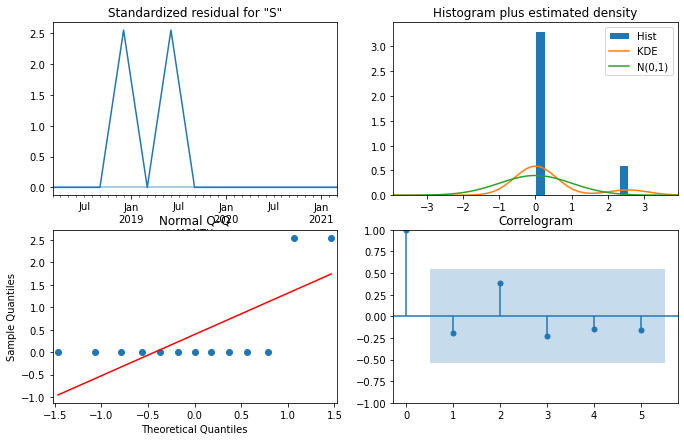

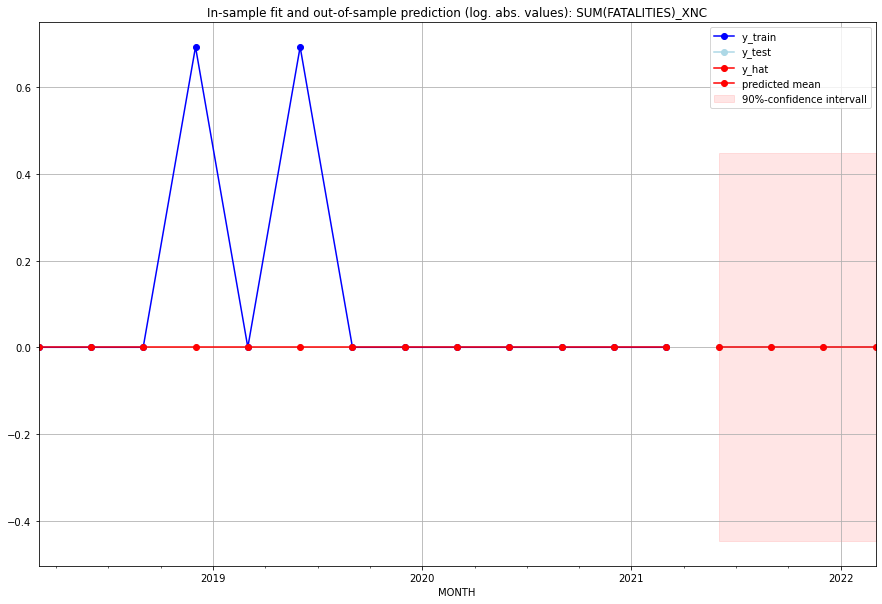

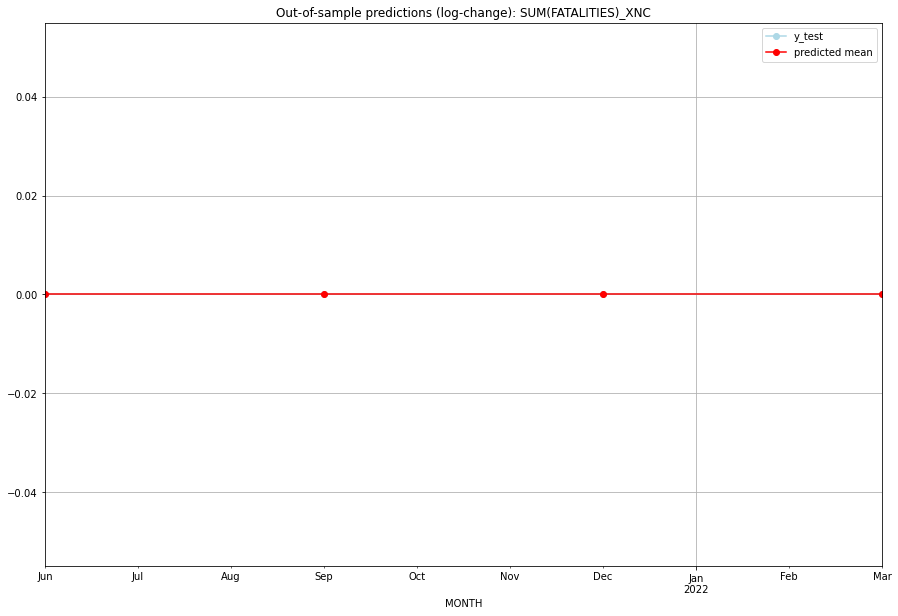

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   XNC   
1 2021-07-01       0.0         0.0           0.0             0.0   XNC   
2 2021-10-01       0.0         0.0           0.0             0.0   XNC   
3 2022-01-01       0.0         0.0           0.0             0.0   XNC   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:13
######## YEM (231/234) #########
0
Neighbor countries: []
Getting Data for YEM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (29, 90)
y: (29, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU cores:
128 paramete

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [1, (3, 1, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.09097461798185247, 'fold_results': [0.09097461798185247]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_YEM   No. Observations:                   25
Model:                SARIMAX(3, 1, 0)   Log Likelihood                 -10.585
Date:                 Sat, 03 Sep 2022   AIC                             31.170
Time:                         20:07:17   BIC                             37.061
Sample:                     01-31-2015   HQIC                            32.733
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0068      0.052     -0.129    

<Figure size 432x288 with 0 Axes>

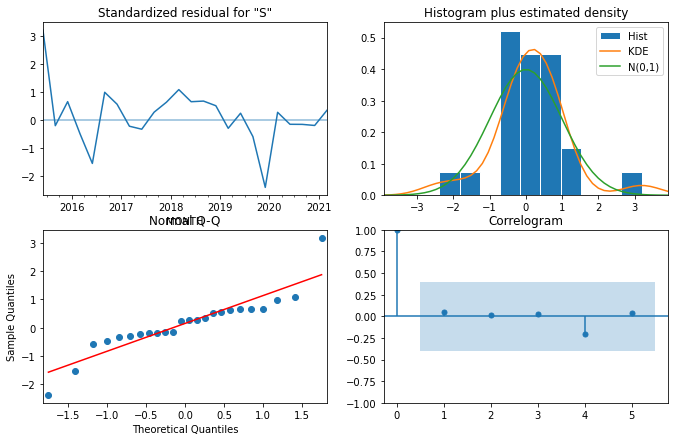

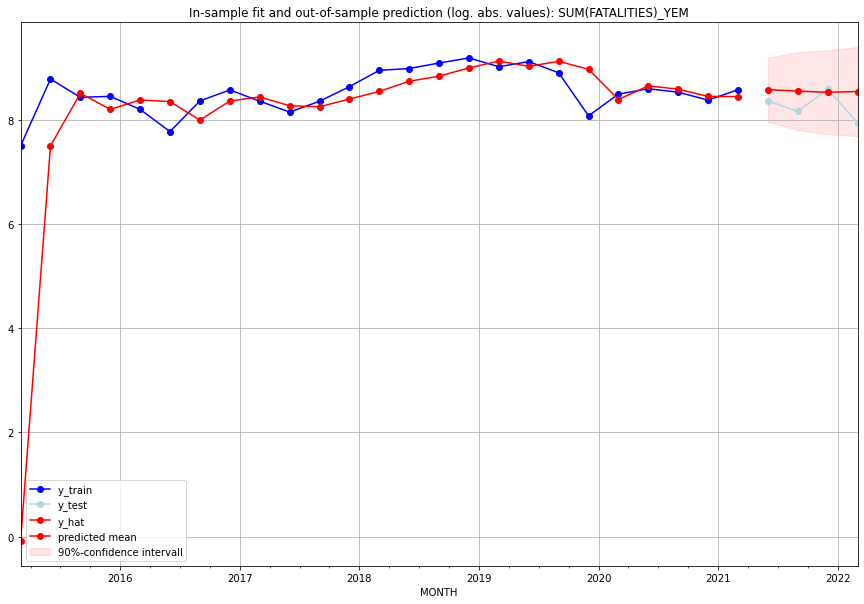

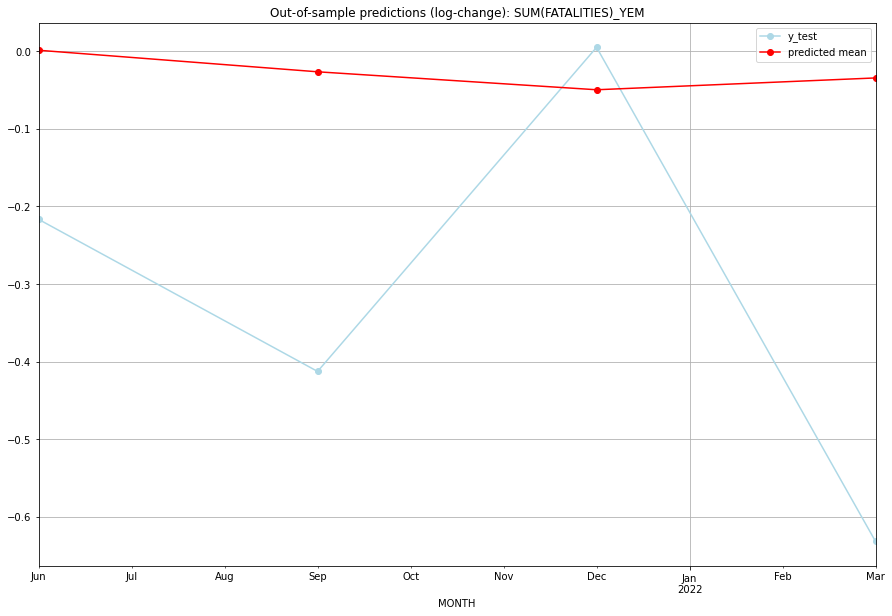

TADDA: 0.32674404449564
Evaluation finished.
       MONTH     FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  5294.850611      4258.0      0.001294       -0.216595   YEM   
1 2021-07-01  5149.880397      3500.0     -0.026462       -0.412581   YEM   
2 2021-10-01  5032.003802      5315.0     -0.049612        0.005092   YEM   
3 2022-01-01  5109.274590      2811.0     -0.034376       -0.631733   YEM   

                                          PARAMETERS  
0  {'params': [1, (3, 1, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [1, (3, 1, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [1, (3, 1, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [1, (3, 1, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:26
######## ZAF (232/234) #########
0
Neighbor countries: []
Getting Data for ZAF
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 95)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH C

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [1, (3, 0, 3), (0, 0, 0, 0), 'n'], 'cv_score': 0.18418710658630721, 'fold_results': [0.18418710658630721]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_ZAF   No. Observations:                   96
Model:                SARIMAX(3, 0, 3)   Log Likelihood                -106.650
Date:                 Sat, 03 Sep 2022   AIC                            229.300
Time:                         20:07:40   BIC                            249.815
Sample:                     04-30-1997   HQIC                           237.593
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1140      0.089      1.276    

<Figure size 432x288 with 0 Axes>

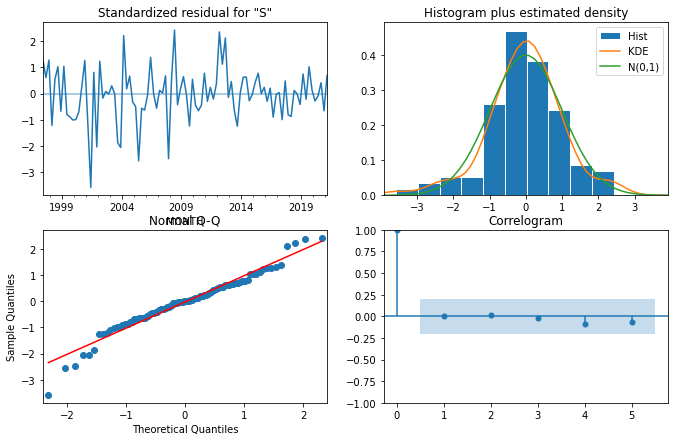

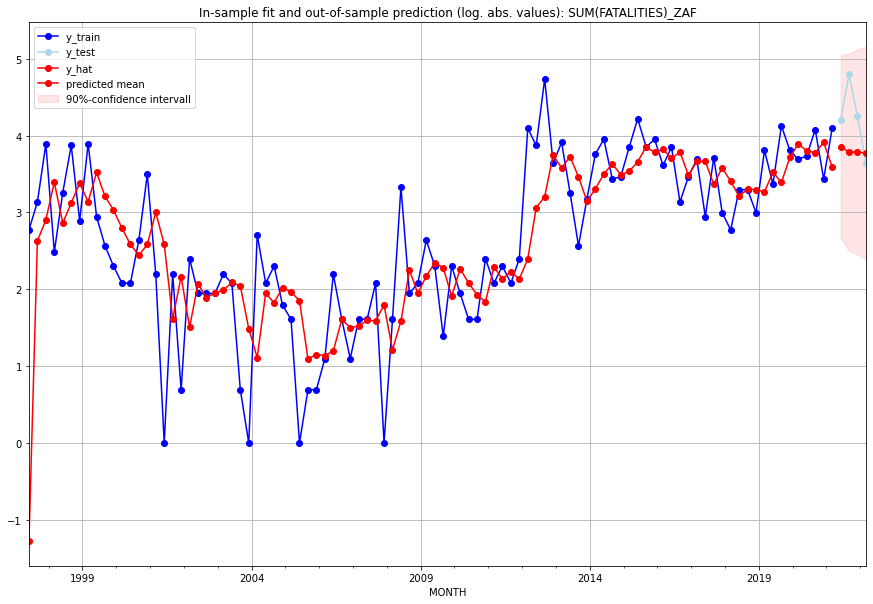

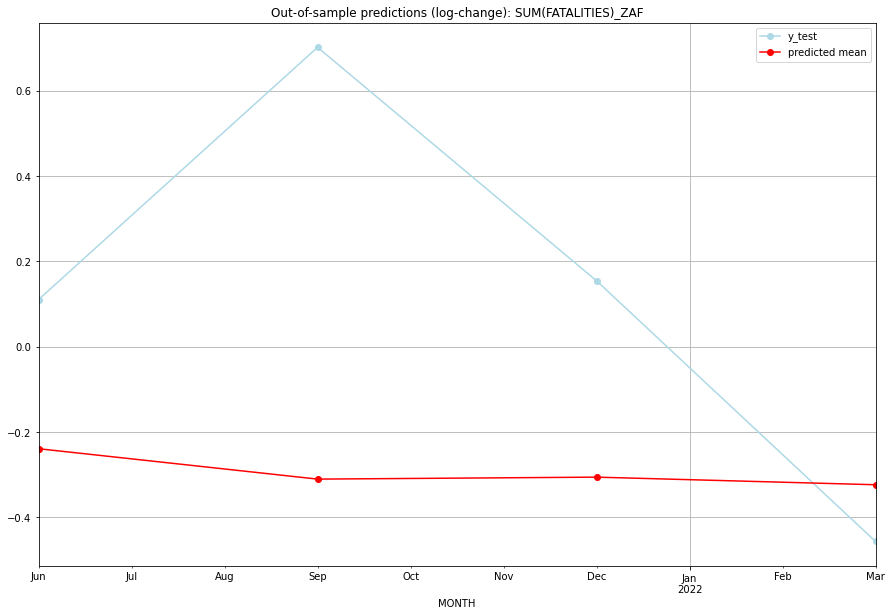

TADDA: 0.7026667249539159
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  46.228718        66.0     -0.239342        0.110348   ZAF   
1 2021-07-01  42.981723       120.0     -0.310570        0.701446   ZAF   
2 2021-10-01  43.185258        69.0     -0.305953        0.154151   ZAF   
3 2022-01-01  42.405057        37.0     -0.323769       -0.456758   ZAF   

                                          PARAMETERS  
0  {'params': [1, (3, 0, 3), (0, 0, 0, 0), 'n'], ...  
1  {'params': [1, (3, 0, 3), (0, 0, 0, 0), 'n'], ...  
2  {'params': [1, (3, 0, 3), (0, 0, 0, 0), 'n'], ...  
3  {'params': [1, (3, 0, 3), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:21
######## ZMB (233/234) #########
0
Neighbor countries: []
Getting Data for ZMB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 90)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 C

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [3, (0, 1, 0), (0, 0, 0, 0), 'n'], 'cv_score': 0.9878109296453537, 'fold_results': [0.9878109296453537]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_ZMB   No. Observations:                   96
Model:                SARIMAX(0, 1, 0)   Log Likelihood                -148.485
Date:                 Sat, 03 Sep 2022   AIC                            304.969
Time:                         20:08:06   BIC                            315.185
Sample:                     04-30-1997   HQIC                           309.097
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0267      0.216     -0.124      

<Figure size 432x288 with 0 Axes>

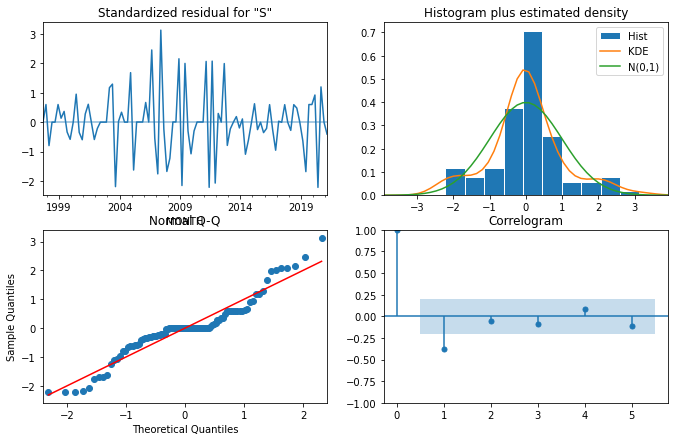

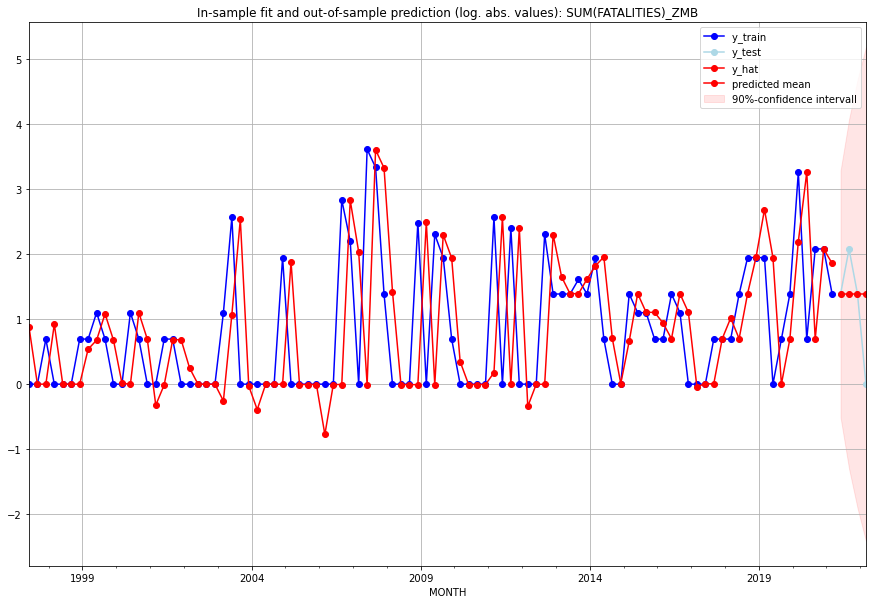

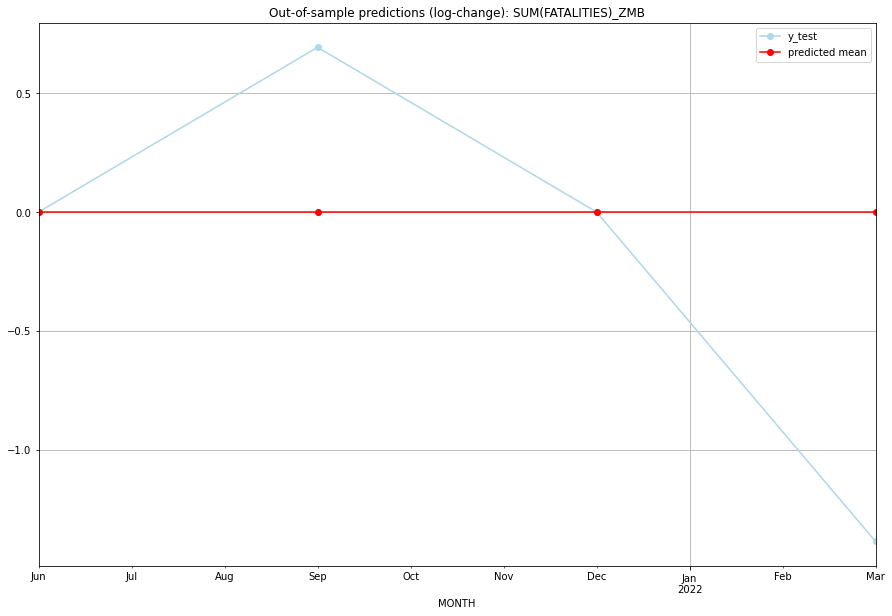

TADDA: 0.5198603854199653
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       3.0         3.0  8.215650e-15        0.000000   ZMB   
1 2021-07-01       3.0         7.0  8.215650e-15        0.693147   ZMB   
2 2021-10-01       3.0         3.0  8.215650e-15        0.000000   ZMB   
3 2022-01-01       3.0         0.0  8.215650e-15       -1.386294   ZMB   

                                          PARAMETERS  
0  {'params': [3, (0, 1, 0), (0, 0, 0, 0), 'n'], ...  
1  {'params': [3, (0, 1, 0), (0, 0, 0, 0), 'n'], ...  
2  {'params': [3, (0, 1, 0), (0, 0, 0, 0), 'n'], ...  
3  {'params': [3, (0, 1, 0), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:26
######## ZWE (234/234) #########
0
Neighbor countries: []
Getting Data for ZWE
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 87)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 8 CPU co

  0%|          | 0/128 [00:00<?, ?it/s]



Best CV-Results
{'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], 'cv_score': 0.8264346069974534, 'fold_results': [0.8264346069974534]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_ZWE   No. Observations:                   96
Model:                SARIMAX(2, 1, 1)   Log Likelihood                -124.291
Date:                 Sat, 03 Sep 2022   AIC                            262.583
Time:                         20:08:32   BIC                            280.460
Sample:                     04-30-1997   HQIC                           269.806
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0106      0.033      0.325      

<Figure size 432x288 with 0 Axes>

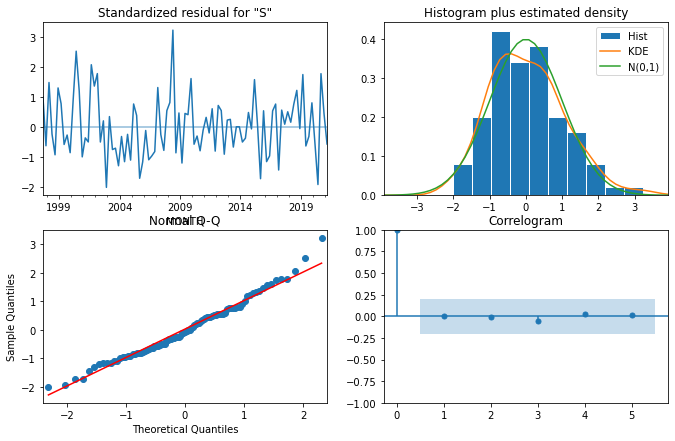

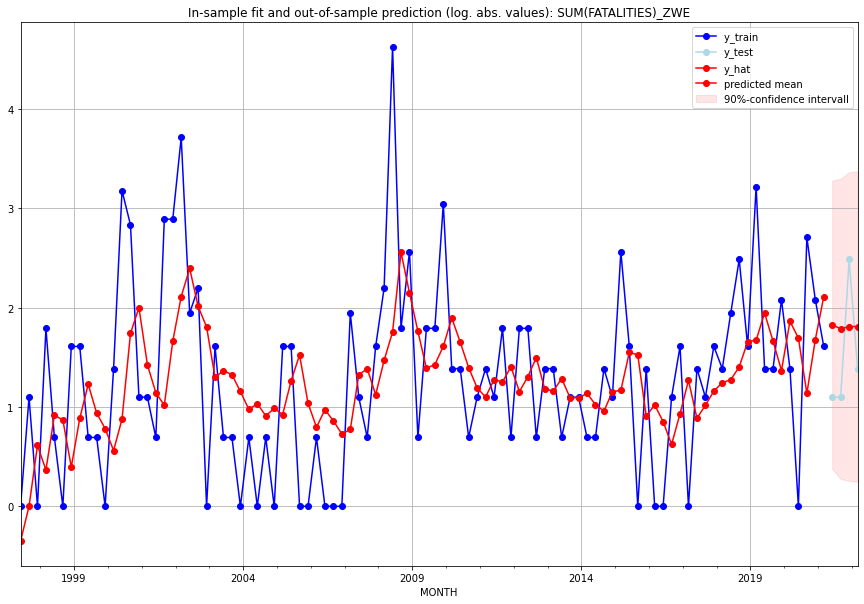

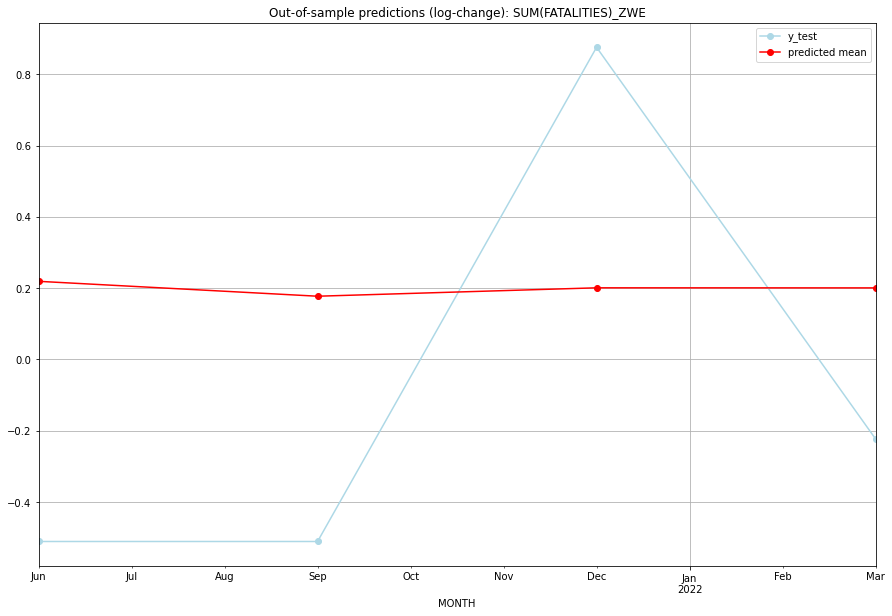

TADDA: 0.7782873264034154
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  5.224271         2.0      0.219018       -0.510826   ZWE   
1 2021-07-01  4.969487         2.0      0.177223       -0.510826   ZWE   
2 2021-10-01  5.111821        11.0      0.200787        0.875469   ZWE   
3 2022-01-01  5.110648         3.0      0.200595       -0.223144   ZWE   

                                          PARAMETERS  
0  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...  
1  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...  
2  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...  
3  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...  
Execution time: 00:25


In [8]:
# warnings.simplefilter(action='ignore')

varimax_res = pd.DataFrame(columns=["MONTH", "FAT_PRED", "FAT_ACTUAL", "LC(FAT_PRED)", "LC(FAT_ACTUAL)", "GID_0", "PARAMETERS", "TIMESTAMP"])
csv_file = "../data/"+MODEL_NAME+"_PREDICTIONS.csv"

if os.path.exists(csv_file):
    existing_res = pd.read_csv("../data/"+MODEL_NAME+"_PREDICTIONS.csv")
    # print(existing_res)
    print("File already exists.")
    
else:
    varimax_res.to_csv(csv_file, index=False, mode="a", header=True)
    existing_res = varimax_res

for i, g in enumerate(gid_list):
# for i, g in enumerate(["XNC"]):
    print("######## "+g+" ("+str(i+1)+"/"+str(len(gid_list))+") #########")
    # print(existing_res[existing_res["GID_0"] == g])
    print(len(existing_res[existing_res["GID_0"] == g]))
    
    
    # skip country if results already exiast
    if len(existing_res[existing_res["GID_0"] == g]) > 0:
        print("Model for this country has already been fitted.")
        continue
    
    # add time series of neighboring  countries as predictor variables

    if NEIGHBORS == True:
        neighbor = gid0_neighbors[gid0_neighbors["GID_0"] == g]["NEIGHBOUR"].tolist()
    else:
        neighbor = []
    print("Neighbor countries: "+ str(neighbor))

    # measure time 
    st = time.time()

    res = varimax(target_variable = TARGET_VARIABLE,
                  target_country = g,
                  predictor_countries = neighbor,
                  n_lags_X = N_LAGS_X,
                  seasonal_periodicity = SEASONAL_PERIODICITY)

    # append country results to csv with timestamp
    res["TIMESTAMP"] = datetime.datetime.now()
    
    res.to_csv(csv_file, index=False, mode="a", header=False)

    et = time.time()
    elapsed_time = et - st
    print('Execution time:', time.strftime("%M:%S", time.gmtime(elapsed_time)))

    varimax_res = pd.concat([varimax_res, res], ignore_index=True)

    # break

In [9]:
# varimax_res.to_csv("../data/"+MODEL_NAME+"_PREDICTIONS.csv", index=False)

In [10]:
varimax_res

MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0   2021-04-01  19.085511        42.0  5.555973e-02        0.816761   THA   
1   2021-07-01  29.053675        20.0  4.585460e-01        0.100083   THA   
2   2021-10-01  24.469356        61.0  2.930370e-01        1.182695   THA   
3   2022-01-01  29.047419         8.0  4.583378e-01       -0.747214   THA   
4   2021-04-01   0.000000        27.0  0.000000e+00        3.332205   TJK   
..         ...        ...         ...           ...             ...   ...   
123 2022-01-01   3.000000         0.0  8.215650e-15       -1.386294   ZMB   
124 2021-04-01   5.224271         2.0  2.190184e-01       -0.510826   ZWE   
125 2021-07-01   4.969487         2.0  1.772230e-01       -0.510826   ZWE   
126 2021-10-01   5.111821        11.0  2.007868e-01        0.875469   ZWE   
127 2022-01-01   5.110648         3.0  2.005949e-01       -0.223144   ZWE   

                                            PARAMETERS  \
0    {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...   
1    {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...   
2    {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...   
3    {'params': [1, (2, 0, 3), (0, 0, 0, 0), 'n'], ...   
4    {'params': [0, (0, 0, 0), (0, 0, 0, 0), 'n'], ...   
..                                                 ...   
123  {'params': [3, (0, 1, 0), (0, 0, 0, 0), 'n'], ...   
124  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...   
125  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...   
126  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...   
127  {'params': [3, (2, 1, 1), (0, 0, 0, 0), 'n'], ...   

                     TIMESTAMP  
0   2022-09-03 20:00:08.463852  
1   2022-09-03 20:00:08.463852  
2   2022-09-03 20:00:08.463852  
3   2022-09-03 20:00:08.463852  
4   2022-09-03 20:00:29.964391  
..                         ...  
123 2022-09-03 20:08:07.879438  
124 2022-09-03 20:08:33.484269  
125 2022-09-03 20:08:33.484269  
126 2022-09-03 20:08:33.484269  
127 2022-09-03 20:08:33.484269  

[128 rows x 8 columns]

In [11]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
